In [1]:
from pathlib import Path
import sys, os
import numpy as np
from pprint import pprint
from copy import deepcopy


# notebook이 examples/selectiveRIP에서 실행 중일 때
repo_root = Path.cwd().resolve().parents[1]  # .../qubit-experiment
sys.path.insert(0, str(repo_root))

In [2]:

from laboneq.simple import *
from laboneq.dsl.device import DeviceSetup
from laboneq.dsl.calibration import Oscillator, SignalCalibration
from laboneq.dsl.enums import ModulationType
from example_helpers.generate_descriptor import generate_descriptor

# descriptor = generate_descriptor(
#     #pqsc=[""], # 장비 여러개 사용시
#     shfqc_6=["DEV12256"],
#     number_data_qubits=3,
#     multiplex=True,
#     number_multiplex=3,
#     include_cr_lines=False,
#     include_ef_lines=True,
#     get_zsync=False,  # Only set to True when using real device
#     save = False, # for using 1 port manually 0121
#     filename="1port",
#     ip_address="192.168.0.83"
# )
# for manually loading 1 port descriptor





#descriptor
#setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")


####Use 1port descriptor############################
desc_path = Path("Descriptors/1port.yaml").resolve()
setup = DeviceSetup.from_yaml(filepath=str(desc_path), server_host="192.168.0.83")
##############################################################
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'


bus_ids = [f"b{i}" for i in range(3)]
bus_port = [3,4,5] #used 1,2,3 for qubit drive

for i, bus in zip(bus_port,bus_ids):
    setup.add_connections(
        setup.instruments[0].uid,
        # each bus uses its own drive:
        create_connection(
            to_signal=f"{bus}/drive",
            ports=f"SGCHANNELS/{i}/OUTPUT"
        ))

# Calibrate qubit drive/measure lines for oscillator phase increments
qubit_ids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
for qubit in qubit_ids:
    for line, frequency, mod_type in [
        ("drive", 5e9, ModulationType.HARDWARE),
        ("drive_ef", 6e9, ModulationType.HARDWARE),
        ("measure", 4e9, ModulationType.SOFTWARE),
    ]:
        logical_signal = setup.logical_signal_by_uid(f"{qubit}/{line}")
        oscillator = Oscillator(modulation_type=mod_type)
        logical_signal.calibration = SignalCalibration(
            local_oscillator=Oscillator(frequency=frequency),
            oscillator=oscillator,
        )
        if line == "measure":
            acquire_signal = setup.logical_signal_by_uid(f"{qubit}/acquire")
            acquire_signal.calibration = SignalCalibration(
                local_oscillator=Oscillator(frequency=frequency),
                oscillator=oscillator,
            )


In [3]:

from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store") 
folder_store.activate()
#folder_store.deactivate()
#workflow.logbook.LoggingStore().activate()
#workflow.logbook.LogbookStore().deactivate()


# Initial QPU

In [4]:
from qpu_types.fixed_transmon import FixedTransmonQubit, FixedTransmonQubitParameters
from qpu_types.bus_cavity import BusCavity, BusCavityParameters
from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
from helper import load_qubit_parameters, save_qubit_parameters

qubit_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
bus_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("b")]

qubits = FixedTransmonQubit.from_device_setup(
    setup, qubit_uids=qubit_uids)
buses = BusCavity.from_device_setup(
    setup, qubit_uids=bus_uids)

qpu = QPU(quantum_elements={"qubits" : qubits, "bus" : buses}, quantum_operations=[FixedTransmonOperations, BusCavityOperations])


# from laboneq.simple import workflow
# folder_store = workflow.logbook.FolderStore("./experiment_store") 
# folder_store.activate()
# #folder_store.deactivate()
# #workflow.logbook.LoggingStore().activate()
# #workflow.logbook.LogbookStore().deactivate()


# SAVE QPU

From now on we save/load QPU elements not QuantumElements

In [8]:
from laboneq.serializers import save, load, from_dict, from_json, to_dict, to_json
import time

t = time.localtime()
timestamp = time.strftime('%Y%m%d-%H%M', t)

filename = "sample3"
save(qpu, filename=f"./qpu_parameters/{timestamp}_{filename}")



# LOAD QPU

Likewise

In [9]:
from datetime import datetime
def find_latest_json(folder_path):
    files = [f for f in os.listdir(folder_path)]
    timestamps = []
    for file in files:
        try:
            # Extract a timestamp assuming it's included in the filename
            timestamp_str = file.split('_', 1)[0]  # Assuming YYYYMMDDHHMMSS format
            timestamp = datetime.strptime(timestamp_str, '%Y%m%d-%H%M%S')
            timestamps.append((timestamp, file))
        except ValueError:
            print("fuck")
            continue  # Skip files that do not match the timestamp format

       # Find the most recent file
    if timestamps:
        latest_file = max(timestamps, key=lambda x: x[0])[1]
        return os.path.join(folder_path, latest_file)
    return None

qb_pars_file = find_latest_json("./qpu_parameters/")
print(f"LOADED: {qb_pars_file}")

from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
import laboneq.dsl.quantum.qpu as qpu_mod

class CombinedOperations(FixedTransmonOperations, BusCavityOperations):
    pass

qpu_mod.CombinedOperations = CombinedOperations

qpu = load(qb_pars_file)

buses = qpu.groups.bus
qubits = qpu.groups.qubits

LOADED: ./qpu_parameters/20260223-0831_sample3


In [ ]:
# data = load(filename=f"./qpu_parameters/20260108-1208_save_test2")
# data.qubits

# Connection

In [6]:
session = Session(setup)
session.connect(do_emulation=False)

[2026.02.23 08:31:04.613] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is c:\Users\user\Documents\GitHub\qubit-experiment\examples\selectiveRIP\laboneq_output\log
[2026.02.23 08:31:04.617] INFO    VERSION: laboneq 25.10.3
[2026.02.23 08:31:04.620] INFO    Connecting to data server at 192.168.0.83:8004
[2026.02.23 08:31:04.644] INFO    Connected to Zurich Instruments LabOne Data Server version 25.10.1.4 at 192.168.0.83:8004
[2026.02.23 08:31:04.678] INFO    Configuring the device setup
[2026.02.23 08:31:04.701] INFO    The device setup is configured


In [ ]:
qubits[0].parameters 

In [7]:
# Q1 q0 -> q0
# # Qubit Drive
qubits[0].parameters.drive_lo_frequency = 4.6e9
qubits[0].parameters.resonance_frequency_ge = 4.2077e9
qubits[0].parameters.resonance_frequency_ef = 4.0e9
qubits[0].parameters.drive_range = 10
qubits[0].parameters.ge_drive_amplitude_pi = 0.6420
qubits[0].parameters.ge_drive_amplitude_pi2 = 0.3213
qubits[0].parameters.ge_drive_length = 128e-9

# # Readout Drive
qubits[0].parameters.readout_lo_frequency = 7.4e9
qubits[0].parameters.readout_resonator_frequency = 7.0020e9
qubits[0].parameters.readout_range_in = 0
qubits[0].parameters.readout_range_out = 0
qubits[0].parameters.readout_amplitude = 0.7
qubits[0].parameters.readout_length = 1.6e-6

qubits[0].parameters.readout_integration_delay = 500e-9
qubits[0].parameters.readout_integration_length = 1100e-9
qubits[0].parameters.readout_pulse = {
            "function": "GaussianSquare",
            "sigma": 0.2,
            "risefall_sigma_ratio": 3.0
        }
qubits[0].parameters.reset_delay_length = 100e-6


# Q2 q1 -> q1
# # Qubit Drive
qubits[1].parameters.drive_lo_frequency = 4.6e9
qubits[1].parameters.resonance_frequency_ge = 4.53807e9
qubits[1].parameters.resonance_frequency_ef = 3.8e9
qubits[1].parameters.drive_range = 10
qubits[1].parameters.ge_drive_amplitude_pi =  0.4584
qubits[1].parameters.ge_drive_amplitude_pi2 = 0.2296
qubits[1].parameters.ge_drive_length = 128e-9

# # Readout Drive
qubits[1].parameters.readout_lo_frequency = 7.4e9
qubits[1].parameters.readout_resonator_frequency = 7.5908e9
qubits[1].parameters.readout_range_in = 0
qubits[1].parameters.readout_range_out = 0
qubits[1].parameters.readout_amplitude = 0.7
qubits[1].parameters.readout_length = 1.6e-6

qubits[1].parameters.readout_integration_delay = 500e-9
qubits[1].parameters.readout_integration_length = 1.1e-6
qubits[1].parameters.readout_pulse = {
            "function": "GaussianSquare",
            "sigma": 0.2,
            "risefall_sigma_ratio": 3.0
        }
qubits[1].parameters.reset_delay_length = 100e-6


# Q3 q1 -> q1
# # Qubit Drive
qubits[2].parameters.drive_lo_frequency = 4.6e9
qubits[2].parameters.resonance_frequency_ge = 4.77635e9
qubits[2].parameters.resonance_frequency_ef = 3.8e9
qubits[2].parameters.drive_range = 10
qubits[2].parameters.ge_drive_amplitude_pi = 0.8063
qubits[2].parameters.ge_drive_amplitude_pi2 = 0.4014
qubits[2].parameters.ge_drive_length = 128e-9

# # Readout Drive
qubits[2].parameters.readout_lo_frequency = 7.4e9
qubits[2].parameters.readout_resonator_frequency = 7.2799e9
qubits[2].parameters.readout_range_in = 0
qubits[2].parameters.readout_range_out = 0
qubits[2].parameters.readout_amplitude = 0.6
qubits[2].parameters.readout_length = 1.6e-6

qubits[2].parameters.readout_integration_delay = 500e-9
qubits[2].parameters.readout_integration_length = 1.1e-6
qubits[2].parameters.readout_pulse = {
            "function": "GaussianSquare",
            "sigma": 0.2,
            "risefall_sigma_ratio": 3.0
        }
qubits[2].parameters.reset_delay_length = 100e-6



# Bus Mode 1
buses[0].parameters.drive_lo_frequency = 5.6e9
buses[0].parameters.resonance_frequency_bus = 5.5042e9
buses[0].parameters.drive_range=10
buses[0].parameters.rip_amplitude=1.0
buses[0].parameters.rip_length=10e-06

buses[0].parameters.rip_detuning = -13e6
buses[0].parameters.custom={}
buses[0].parameters.rip_pulse={
   'function': 'NestedCosine'
   }
buses[0].parameters.kappa=None

# bus mode 2
buses[1].parameters.resonance_frequency_bus = 6.4214e9
buses[1].parameters.rip_detuning = -13e6
buses[1].parameters.drive_lo_frequency = 6.2e9
# bus mode 3
buses[2].parameters.resonance_frequency_bus = 5.9087e9
buses[2].parameters.rip_detuning = -13e6
buses[2].parameters.drive_lo_frequency = 6.2e9


In [ ]:
qubits[0].parameters.drive_range

In [ ]:
qubits[2].parameters.drive_range
qubits[2].parameters.resonance_frequency_ge 
#qubits[2].parameters.ge_drive_length 

In [ ]:
rabi_amp_result.tasks['analysis_workflow'].output[]

#qubits[1].parameters.readout_resonator_frequency 

# Calibration

## Resonator Spectroscopy

In [ ]:
qubits[0].parameters.readout_range_out

In [ ]:
from helper import adjust_amplitude_for_output_range, calculate_power
#adjust_amplitude_for_output_range(initial_output_dbm=0, initial_amplitude= 0.002, new_output_dbm=-5)
calculate_power(output_dbm=10, amplitude=0.001,attenuation=[])

In [ ]:
qubits[1].parameters.reset_delay_length

In [ ]:
qubits[1].parameters

In [ ]:
from laboneq_applications.experiments import resonator_spectroscopy

####################################################################################
q=qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
#temp_pars = qubits[2].parameters

# temp_pars.readout_resonator_frequency = 7.0022e9 #6.04036e9 #mode1
# temp_pars.readout_amplitude = 0.5
# temp_pars.readout_length = 1300e-9
# temp_pars.readout_integration_delay = 400e-9
# temp_pars.readout_integration_length = 1300e-9

temporary_parameters[q.uid] = temp_pars
print(q.readout_parameters())
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#frequencies = q.parameters.readout_resonator_frequency + np.linspace(-10e6,10e6,501)
frequencies = temp_pars.readout_resonator_frequency + np.linspace(-5.0e6,5.0e6,501)
#####################################################################################
options = resonator_spectroscopy.experiment_workflow.options()
#workflow.show_fields(options)
options.count(1024)
options.update(False)
options.use_cw(False)#qop.measure 
#options.fit_complex_resonator(False)
#options.fit_lorentzian(True)
######################################################################################
# Build and run resonator_spectroscopy_amplitude wormflow
res_spec = resonator_spectroscopy.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    frequencies=frequencies,
    options=options,
    temporary_parameters=temporary_parameters,
)
res_spec_result = res_spec.run()
res_spec_analysis_result = res_spec_result.tasks["analysis_workflow"]
pprint(res_spec_analysis_result.output)

In [ ]:
res_spec_analysis_result.output['new_parameter_values']['q0']

qubits[1].parameters.readout_resonator_frequency = 7589360000.0

In [ ]:
# from laboneq.simple import show_pulse_sheet
# from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# show_pulse_sheet(compiled_experiment=res_spec_result.tasks["compile_experiment"].output,name='test', interactive=True)
# #plot_simulation(compiled_experiment=res_spec_result.tasks["compile_experiment"].output)

## Qubit spec

In [ ]:
qubits[0].parameters.sp

In [ ]:
from experiments import qubit_spectroscopy

###############################################################
q = qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
#temp_pars = qubits[2].parameters
temp_pars.drive_range = 0
temp_pars.spectroscopy_amplitude = 0.03 #0.006 #0.003
temp_pars.spectroscopy_length = 10e-6
# temp_pars.resonance_frequency_ge = 4.48e9
# temp_pars.readout_range_out = 0
# temp_pars.readout_amplitude = 0.5
temporary_parameters[q.uid] = temp_pars

#q.parameters.readout_amplitude = 1.0
frequencies = temp_pars.resonance_frequency_ge+ np.linspace(-4e6, 4e6, 101)
#print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
pprint(q.readout_parameters())
pprint(q.spectroscopy_parameters())
################################################################
options = qubit_spectroscopy.experiment_workflow.options()
options.update(False)
options.count(1024)
# workflow.show_fields(options)
###################################################################
qubit_spec = qubit_spectroscopy.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    frequencies=frequencies,
    options=options,
    temporary_parameters=temporary_parameters
)

qubit_spec_result = qubit_spec.run()
qubit_spec_result

In [ ]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

show_pulse_sheet(compiled_experiment=qubit_spec_result.tasks["compile_experiment"].output,name='test', interactive=True)
plot_simulation(compiled_experiment=qubit_spec_result.tasks["compile_experiment"].output, length=5e-6)

## Rabi

In [ ]:
from laboneq_applications.experiments import amplitude_rabi
q = qubits[2]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
# temp_pars = qubits[2].parameters
#temp_pars.ge_drive_length = 128e-9
#temp_pars.readout_amplitude= 0.5
temp_pars.readout_length = 1.6e-6
temp_pars.readout_integration_length = 1.6e-6
temporary_parameters[q.uid] = temp_pars

#######################################################################
amplitudes = np.linspace(0.0, 1.0,101)
print(q.parameters.ge_drive_amplitude_pi)
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = amplitude_rabi.experiment_workflow.options()
options.update(False)
options.use_cal_traces(True)
options.count(1024)
#print(workflow.show_fields(options))

###################################################################
rabi_amp = amplitude_rabi.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    amplitudes=amplitudes,
    options=options,
    temporary_parameters = temporary_parameters
)

rabi_amp_result = rabi_amp.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(rabi_amp_result.tasks['analysis_workflow'].output)

## Ramsey 

In [ ]:
from laboneq_applications.experiments import ramsey


q = qubits[2]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
# temp_pars = qubits[0].parameters
# temp_pars.resonance_frequency_ge = 4.9528e9
# temp_pars.readout_length = 1.2e-6
# temp_pars.readout_amplitude=0.65
temp_pars.readout_length = 1.2e-6
temp_pars.readout_integration_length = 1.2e-6
temporary_parameters[q.uid] = temp_pars


#######################################################################
delays = np.linspace(0,15e-6,151)
detunings = 0.3e6,
pprint(q.readout_parameters())
#######################################################################
options = ramsey.experiment_workflow.options()
options.update(False)
options.count(1024)
options.use_cal_traces(True)
# Build and run Ramsey workflow (no explicit command table options required)
ramsey_wf = ramsey.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    delays=delays,
    detunings=detunings,
    options=options,
    temporary_parameters=temporary_parameters
)
ramsey_result = ramsey_wf.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(ramsey_result.tasks['analysis_workflow'].output)

In [ ]:
ramsey_result.tasks['analysis_workflow'].output

#qubits[1].parameters.readout_resonator_frequency 

## X90

In [ ]:
from laboneq_applications.experiments import amplitude_fine
q = qubits[2]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
# temp_pars = qubits[2].parameters

# temp_pars.readout_length = 1.4e-6
temp_pars.readout_integration_length = 1600e-9

temporary_parameters[q.uid] = temp_pars
#######################################################################
repetitions =np.arange(1,10)
#######################################################################
options = amplitude_fine.experiment_workflow_x90.options()
options.update(False) 
options.use_cal_traces(True)
options.do_pca(False)
options.count(1024)

#print(workflow.show_fields(options))

###################################################################
error_amp_half = amplitude_fine.experiment_workflow_x90(
    session=session,
    qpu=qpu,
    qubits=q,
    repetitions=repetitions,
    temporary_parameters=temporary_parameters,
    options=options
)

error_amp_half_result = error_amp_half.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(error_amp_half_result.tasks['analysis_workflow'].output)

## X180

In [ ]:
from laboneq_applications.experiments import amplitude_fine
q = qubits[2]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
# temp_pars = qubits[2].parameters
# temp_pars.readout_amplitude=0.5
# temp_pars.readout_length = 1.4e-6
temp_pars.readout_integration_length = 1.6e-6

temporary_parameters[q.uid] = temp_pars

#######################################################################
repetitions =np.arange(1,14) # Due to short T1, 20   
#######################################################################
options = amplitude_fine.experiment_workflow_x180.options()
options.update(False)
options.use_cal_traces(True)
#options.do_pca(False)

#print(workflow.show_fields(options))

###################################################################
error_amp = amplitude_fine.experiment_workflow_x180(
    session=session,
    qpu=qpu,
    qubits=q,
    repetitions=repetitions,
    temporary_parameters=temporary_parameters,
    options=options
)

error_amp_result = error_amp.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(error_amp_result.tasks['analysis_workflow'].output)

## IQ traj

In [ ]:
from experiments import iq_traj

####################################################################################
q=qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
# temp_pars = qubits[2].parameters

temp_pars.readout_resonator_frequency = 7.0020e9
temp_pars.readout_amplitude = 0.7
temp_pars.readout_length = 1.6e-6
temp_pars.readout_integration_delay = 500e-9
temp_pars.readout_integration_length = 1100e-9

temporary_parameters[q.uid] = temp_pars
#######################################################################
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
pprint(q.readout_parameters())
#######################################################################
options = iq_traj.experiment_workflow.options()
options.count(2**14)
options.do_analysis(True)

#print(workflow.show_fields(options))

###################################################################
iq_t = iq_traj.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    options=options,
    states='ge',
    temporary_parameters=temporary_parameters
)

iq_traj_result = iq_t.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
iq_traj_result.tasks['analysis_workflow'].tasks['plot_iq_trajectories'].output[q.uid]

## IQ blobs

In [ ]:
from experiments import iq_blobs

#######################################################################
q = qubits[0]

temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
# temp_pars = qubits[2].parameters

# temp_pars.readout_resonator_frequency = 7.2783e9
# temp_pars.readout_amplitude = 0.7
temp_pars.readout_length = 1.6e-6
temp_pars.readout_integration_delay = 500e-9
temp_pars.readout_integration_length = 1100e-9

temporary_parameters[q.uid] = temp_pars
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = iq_blobs.experiment_workflow.options()
options.count(2**14)
#print(workflow.show_fields(options))

###################################################################
iq = iq_blobs.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    options=options,
    states='ge',
    temporary_parameters=temporary_parameters
)
iq_blob_result = iq.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
iq_blob_result.tasks['analysis_workflow'].tasks['plot_iq_blobs'].output[q.uid]
print(iq_blob_result.tasks['analysis_workflow'].output)

# Characterization

## T1

In [ ]:
from laboneq_applications.experiments import lifetime_measurement


###############################################################
q = qubits[1]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
# temp_pars = qubits[0].parameters

# temp_pars.readout_amplitude = 0.5
# temp_pars.readout_length = 1.2e-6
temp_pars.readout_integration_length = 1.2e-6
temp_pars.readout_length = 1.2e-6

temporary_parameters[q.uid] = temp_pars


print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
pprint(q.readout_parameters())
pprint(q.spectroscopy_parameters())
################################################################
options = lifetime_measurement.experiment_workflow.options()
options.update(False)
options.count(1024)
# workflow.show_fields(options)
###################################################################
t1 = lifetime_measurement.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    options=options,
    delays = np.linspace(0e-6, 20e-6, 101),
    temporary_parameters = temporary_parameters, 
)

t1_result = t1.run()

## RB

In [ ]:
#from laboneq_applications.experiments import 
from experiments import single_qubit_randomized_benchmarking
q = qubits[0]
# temporary_parameters = {}
# temp_pars =deepcopy(q.parameters)
# temporary_parameters[q.uid] = temp_pars

#############################################
options = single_qubit_randomized_benchmarking.experiment_workflow.options()
options.count(1024)
options.transition("ge")


rb = single_qubit_randomized_benchmarking.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    length_cliffords=[1,5,10,20,50],
    variations=50,
    options=options,
)

rb_result = rb.run()

#######################################################################

In [ ]:
# qubits[1].parameters.readout_integration_delay = 340e-9
# qubits[1].parameters.readout_length = 1.0e-6
# qubits[1].parameters.readout_integration_length = 0.6e-6
# qubits[1].parameters.readout_resonator_frequency = 7.2360e9
# qubits[1].parameters.readout_amplitude = 0.7

## Dispersive Shift

In [ ]:

from experiments import dispersive_shift

#######################################################################
q = qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temp_pars = qubits[2].parameters
temp_pars.readout_amplitude=0.5
#temp_pars.readout_resonator_frequency = 7.5582e9
temporary_parameters[q.uid] = temp_pars

print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = dispersive_shift.experiment_workflow.options()
options.count(1024*2)
options.update(False)
#print(workflow.show_fields(options))

###################################################################
dispersive = dispersive_shift.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    #frequencies=q.parameters.readout_resonator_frequency + np.linspace(-5e6,5e6,201),
    frequencies=qubits[2].parameters.readout_resonator_frequency + np.linspace(-4e6,4e6,201),
    options=options,
    states='ge',
    temporary_parameters=temporary_parameters
)

dispersive_result = dispersive.run() 
print(dispersive_result.tasks['analysis_workflow'].output)

## Coherence spec

In [ ]:
buses[0].parameters

In [ ]:
from experiments import coherence_spectroscopy


####################################################################################
q=qubits[0]
b=buses[0]
temporary_parameters = {}
q_temp_pars =deepcopy(q.parameters)
q_temp_pars.readout_amplitude = 0.65
# q_temp_pars.readout_integration_length =1.6e-6
b_temp_pars =deepcopy(b.parameters)
bus1 = 5.505e9
bus2 = 5.9786e9
bus3 = 6.4205e9
b_temp_pars.drive_lo_frequency = 5.6e9
b_temp_pars.resonance_frequency_bus = bus1
#b_temp_pars.readout_integration_length =1e-6
# b_temp_pars.drive_lo_frequency = 6.0e9
temporary_parameters[q.uid] = q_temp_pars
temporary_parameters[b.uid] = b_temp_pars

print(q.readout_parameters())

#####################################################################################
options = coherence_spectroscopy.experiment_workflow.options()
#workflow.show_fields(options)
options.count(256)
options.update(False)
options.do_analysis(True)
options.ring_up(10e-6)
options.ring_down(16e-9)

######################################################################################
# Build and run resonator_spectroscopy_amplitude wormflow
co_spec = coherence_spectroscopy.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    bus= b,
    delays=np.linspace(0,8e-6,41), #delays=np.linspace(0,5e-6,21), 포인트 확보 중요
    CW_frequencies= b_temp_pars.resonance_frequency_bus+np.linspace(-1.0e6,1.0e6,81),
    #CW_frequencies= 5.5555e9 +np.linspace(-0.6e6,0.6e6,101),
    CW_amplitude=0.0023,
    CW_phase=0.0,
    detunings=0.6e6,
    temporary_parameters=temporary_parameters,
    options=options
)
co_spec_result = co_spec.run()
#co_spec_analysis_result = co_spec_result.tasks["analysis_workflow"]

In [ ]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# show_pulse_sheet(compiled_experiment=co_spec_result.tasks["compile_experiment"].output,name='test', interactive=True)
plot_simulation(compiled_experiment=co_spec_result.tasks["compile_experiment"].output, length=25e-6)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from experiments import coherence_spectroscopy
CW_amps = np.array([0.0014, 0.0016, 0.0018])

q=qubits[1]
b=buses[0]
results = {k: {"val": [], "err": []} for k in ["kappa","chi","epsilon_rf","bare_freq"]}

for CW_amp in CW_amps:
    co_spec = coherence_spectroscopy.experiment_workflow(
        session=session,
        qpu=qpu,
        qubit=q,
        bus=b,
        delays=np.linspace(0, 20e-6, 21),
        CW_frequencies=b.parameters.resonance_frequency_bus + np.linspace(-1.0e6, 1.0e6, 11),
        CW_amplitude=CW_amp,   # <-- 
        CW_phase=0.0,
        detunings=0.4e6,
        temporary_parameters=temporary_parameters,
        options=options
    )
    co_spec_result = co_spec.run()
    fit = co_spec_result.tasks["analysis_workflow"].tasks["fit_mid_rate_data"].output["q1"]

    # fit 실패 대비
    if fit is None:
        for k in results:
            results[k]["val"].append(np.nan)
            results[k]["err"].append(np.nan)
        continue

    for k in results:
        p = fit.params[k]
        results[k]["val"].append(p.value)
        results[k]["err"].append(p.stderr if p.stderr is not None else np.nan)

# plot (4개 파라미터)
fig, axes = plt.subplots(2, 2, figsize=(8,6), sharex=True)
axes = axes.ravel()
for ax, k in zip(axes, ["kappa","chi","epsilon_rf","bare_freq"]):
    ax.errorbar(CW_amps, results[k]["val"], yerr=results[k]["err"], fmt="o-", capsize=3)
    ax.set_title(k)
    ax.set_xlabel("CW amplitude")
    ax.set_ylabel(k)
plt.tight_layout()


## Photon number calibration

In [ ]:
from experiments import photonnumber_calibration_6

q = qubits[2]
b = buses[0]

temporary_parameters = {}
q_temp_pars = deepcopy(q.parameters)
q_temp_pars.spectroscopy_amplitude = 0.075
q_temp_pars.spectroscopy_length = 1.6e-6
q_temp_pars.readout_amplitude = 0.5
b_temp_pars = deepcopy(b.parameters)
b_temp_pars.drive_range = -10.0

temporary_parameters[q.uid] = q_temp_pars
temporary_parameters[b.uid] = b_temp_pars

options = photonnumber_calibration_6.experiment_workflow.options()
options.count(1024)
options.bus_pulse_length(200.0e-9)

# Qubit frequency sweep (넓게)
frequencies = q_temp_pars.resonance_frequency_ge + np.linspace(-18.0e6, 2.0e6, 401)

pn_spec = photonnumber_calibration_6.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    bus=b,
    frequencies=frequencies,
    CW_amplitude=0.45,
    CW_frequency=b.parameters.resonance_frequency_bus,
    temporary_parameters=temporary_parameters,
    options=options
)

pn_spec_result = pn_spec.run()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 결과 데이터 가져오기
result = pn_spec_result.tasks["run_experiment"].output

# 데이터 및 축 정보 추출
data = result.get_data("q2/result")
axis = result.get_axis("q2/result")
frequencies = np.array(axis[0])

# 기준 주파수 (qubit resonance)
f0 = 4.7764e9  # 필요하면 조절

# Magnitude와 Phase
magnitude = np.abs(data)
phase = np.angle(data, deg=True)

# Real과 Imag
real = np.real(data)
imag = np.imag(data)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Magnitude
axes[0, 0].plot((frequencies - f0) / 1e6, magnitude, 'o', markersize=4, color='blue')
axes[0, 0].set_ylabel('Magnitude (a.u.)')
axes[0, 0].set_title('Magnitude')
axes[0, 0].grid(True)

# Phase
axes[0, 1].plot((frequencies - f0) / 1e6, phase, 'o', markersize=4, color='green')
axes[0, 1].set_ylabel('Phase (deg)')
axes[0, 1].set_title('Phase')
axes[0, 1].grid(True)

# Real
axes[1, 0].plot((frequencies - f0) / 1e6, real, 'o-', markersize=4, color='orange')
axes[1, 0].set_xlabel('Frequency detuning (MHz)')
axes[1, 0].set_ylabel('Real (a.u.)')
axes[1, 0].set_title('Real')
axes[1, 0].grid(True)

# Imag
axes[1, 1].plot((frequencies - f0) / 1e6, imag, 'o-', markersize=4, color='red')
axes[1, 1].set_xlabel('Frequency detuning (MHz)')
axes[1, 1].set_ylabel('Imag (a.u.)')
axes[1, 1].set_title('Imag')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# 결과 데이터 가져오기
result = pn_spec_result.tasks["run_experiment"].output

data = result.get_data("q2/result")
axis = result.get_axis("q2/result")
frequencies = np.array(axis[0])

f0 = 4.7674e9
real = np.real(data)
freq_MHz = (frequencies - f0) / 1e6

# ============================================
# 초기 조건 - peak 기준으로
# ============================================
two_chi_init = 2.5   # 2χ 초기값 (MHz)
n_peaks = 6          # fitting할 peak 개수
x0_init = 8.5        # n=0 위치 (MHz) - 가장 오른쪽 peak
gamma_init = 0.5     # linewidth (MHz)
offset_init = -0.15  # baseline - 데이터 최저값 근처
# ============================================


def multi_lorentzian(x, offset, gamma, two_chi, x0, *amplitudes):
    result = np.ones_like(x) * offset
    for i, A in enumerate(amplitudes):
        center = x0 - i * two_chi
        result += A * (gamma/2)**2 / ((x - center)**2 + (gamma/2)**2)
    return result


# Initial guess
p0 = [offset_init, gamma_init, two_chi_init, x0_init]
for i in range(n_peaks):
    p0.append(0.1)  # positive amplitude for peaks

# Bounds
lower_bounds = [-0.3, 0.5, 2.0, 5.0]   # offset, gamma, 2chi, x0
upper_bounds = [0.0, 5.0, 6.0, 12.0]
for i in range(n_peaks):
    lower_bounds.append(0.0)   # positive amplitude
    upper_bounds.append(0.3)

# Fitting
popt, pcov = curve_fit(
    multi_lorentzian, 
    freq_MHz, 
    real, 
    p0=p0, 
    bounds=(lower_bounds, upper_bounds),
    maxfev=20000
)
perr = np.sqrt(np.diag(pcov))

# 결과
offset_fit, gamma_fit, two_chi_fit, x0_fit = popt[:4]
amplitudes = popt[4:]

print("=" * 50)
print("Fit Results")
print("=" * 50)
print(f"2χ: {two_chi_fit:.3f} ± {perr[2]:.3f} MHz")
print(f"χ/2π: {two_chi_fit/2:.3f} MHz")
print(f"Linewidth (γ): {gamma_fit:.3f} ± {perr[1]:.3f} MHz")
print(f"n=0 position: {x0_fit:.3f} MHz")

# Photon distribution
peak_amps = np.abs(amplitudes)
peak_amps_norm = peak_amps / np.sum(peak_amps)
n_values = np.arange(n_peaks)
n_bar = np.sum(n_values * peak_amps_norm)

print(f"\nPhoton number distribution:")
for i, p in enumerate(peak_amps_norm):
    print(f"  P(n={i}) = {p:.3f}")
print(f"\nn̄ = {n_bar:.2f}")

# Plot
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

freq_fine = np.linspace(freq_MHz.min(), freq_MHz.max(), 500)
fit_curve = multi_lorentzian(freq_fine, *popt)

axes[0].plot(freq_MHz, real, 'o-', markersize=4, alpha=0.6, label='Data')
axes[0].plot(freq_fine, fit_curve, 'r-', lw=2, label='Fit')
for i in range(n_peaks):
    center = x0_fit - i * two_chi_fit
    axes[0].axvline(center, color='gray', ls='--', alpha=0.5)
    axes[0].text(center, np.max(real) + 0.01, f'n={i}', ha='center')
axes[0].set_xlabel('Frequency detuning (MHz)')
axes[0].set_ylabel('Real (a.u.)')
axes[0].set_title(f'Photon Number Splitting (2χ = {two_chi_fit:.2f} MHz)')
axes[0].legend()
axes[0].grid(True)

axes[1].bar(n_values, peak_amps_norm, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Photon number n')
axes[1].set_ylabel('P(n)')
axes[1].set_title(f'Photon Number Distribution (n̄ = {n_bar:.2f})')
axes[1].set_xticks(n_values)
axes[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

In [ ]:
from scipy.optimize import curve_fit
from scipy.special import factorial

# Poisson distribution
def poisson(n, n_bar):
    return np.exp(-n_bar) * (n_bar ** n) / factorial(n)

# Fit
popt_poisson, _ = curve_fit(poisson, n_values, peak_amps_norm, p0=[n_bar])
n_bar_poisson = popt_poisson[0]

print(f"\nDirect calculation: n̄ = {n_bar:.2f}")
print(f"Poisson fit: n̄ = {n_bar_poisson:.2f}")

# 비교 plot
fig, ax = plt.subplots(figsize=(8, 5))
width = 0.35
ax.bar(n_values - width/2, peak_amps_norm, width, label='Measured', color='steelblue')
ax.bar(n_values + width/2, poisson(n_values, n_bar_poisson), width, label=f'Poisson (n̄={n_bar_poisson:.2f})', color='orange', alpha=0.7)
ax.set_xlabel('Photon number n')
ax.set_ylabel('P(n)')
ax.legend()
ax.set_xticks(n_values)
plt.show()

In [ ]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

show_pulse_sheet(compiled_experiment=pn_spec_result.tasks["compile_experiment"].output,name='test', interactive=True)
# plot_simulation(compiled_experiment=pn_cal_result.tasks["compile_experiment"].output, length=30e-6)
plot_simulation(
    compiled_experiment=pn_spec_result.tasks["compile_experiment"].output,
    start_time=0.0e-6,  # 시작 시간
    length=3e-6       # 그 시점부터 볼 길이
)

## cavity T1

In [ ]:
from experiments import cavity_T1_2
from copy import deepcopy
import numpy as np

q = qubits[2]
b = buses[0]

# Temporary parameters
temporary_parameters = {}
q_temp_pars = deepcopy(q.parameters)
q_temp_pars.readout_amplitude = 0.5
b_temp_pars = deepcopy(b.parameters)
b_temp_pars.drive_range = -10

temporary_parameters[q.uid] = q_temp_pars
temporary_parameters[b.uid] = b_temp_pars

# Sweep parameters
delays = np.linspace(0, 8e-6, 81)

# Options
options = cavity_T1_2.experiment_workflow.options()
options.count(1024)
options.bus_pulse_length(64e-9)

# Run with for loop
c_T1_results = []
for delay in delays:
    cav_t1 = cavity_T1_2.experiment_workflow(
        session=session,
        qpu=qpu,
        qubit=q,
        bus=b,
        delay_time=delay,
        CW_amplitude=0.27,
        CW_frequency=b.parameters.resonance_frequency_bus,
        temporary_parameters=temporary_parameters,
        options=options,
    )
    c_T1_result = cav_t1.run()
    c_T1_results.append(c_T1_result)
    print(f"Delay {delay*1e6:.1f} µs done")



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터를 담을 리스트 초기화
I_list = []
Q_list = []

# 2. results 리스트를 돌면서 데이터 추출
# c_T1_results는 loop를 돌며 append한 결과 리스트라고 가정합니다.
# handle_name은 "q2/result" 또는 f"{q.uid}/result"
for i, res in enumerate(c_T1_results):
    # 각 딜레이 단계의 output 가져오기
    output = res.tasks["run_experiment"].output
    raw_data = output.acquired_results[handle_name].data
    
    # 실수부(I)와 허수부(Q) 분리하여 저장
    I_list.append(np.real(raw_data))
    Q_list.append(np.imag(raw_data))

# 3. Numpy 배열로 변환 (데이터 처리를 쉽게 하기 위해)
I_array = np.array(I_list) # Shape: (Delay 개수, Frequency 개수) 또는 (Delay 개수,)
Q_array = np.array(Q_list)

# 4. x축 생성 (n = 0, 1, 2, ...)
n_indices = np.arange(len(I_array))

# 5. 그래프 그리기
plt.figure(figsize=(14, 6))

# 데이터 차원에 따라 처리 방식 결정
if I_array.ndim > 1:
    # Case A: 주파수 스윕 데이터인 경우 (2D Array)
    # 가장 신호가 강한(Magnitude가 큰) 주파수 지점을 자동으로 찾아서 그립니다.
    magnitude_avg = np.abs(I_array + 1j * Q_array).mean(axis=0)
    peak_idx = np.argmax(magnitude_avg) # 평균적으로 가장 신호가 센 주파수 인덱스
    
    print(f"Spectroscopy Data Detected.")
    print(f"Plotting values at Frequency Index {peak_idx} (Max Amplitude).")
    
    y_I = I_array[:, peak_idx]
    y_Q = Q_array[:, peak_idx]
    
else:
    # Case B: 단일 포인트 데이터인 경우 (1D Array)
    y_I = I_array
    y_Q = Q_array

# --- I Component Plot ---
plt.subplot(1, 2, 1)
plt.plot(n_indices, y_I, 'o-', color='blue', label='I Component')
plt.title(f"I Component vs n (Delay Index)")
plt.xlabel("Index n", fontsize=20)
plt.ylabel("I Amplitude (a.u.)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=16)

# --- Q Component Plot ---
plt.subplot(1, 2, 2)
plt.plot(n_indices, y_Q, 's-', color='orange', label='Q Component')
plt.title(f"Q Component vs n (Delay Index)")
plt.xlabel("Index n", fontsize=20)
plt.ylabel("Q Amplitude (a.u.)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=16)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# 1. 데이터를 담을 리스트 준비
data_rows = []

# 2. 결과 핸들(Handle) 이름 자동 찾기 (첫 번째 결과에서 확인)
# ---------------------------------------------------------
first_output = c_T1_results[0].tasks["run_experiment"].output
# 딕셔너리의 첫 번째 키를 가져옴 (예: 'q2/result')
handle_name = list(first_output.acquired_results.keys())[0]
print(f"Extracting data from handle: {handle_name}")
# ---------------------------------------------------------

# 3. 루프를 돌며 데이터 추출
for i, delay in enumerate(delays):
    # i번째 실험 결과 가져오기
    output = c_T1_results[i].tasks["run_experiment"].output
    raw_data = output.acquired_results[handle_name].data
    
    # 데이터가 배열일 경우를 대비해 스칼라 값으로 변환 (평균)
    # T1 실험은 보통 포인트 당 하나의 값이므로 바로 값을 씁니다.
    val = np.mean(raw_data) 
    
    # 저장할 행(Row) 데이터 생성
    row = {
        "Delay (s)": delay,
        "I (a.u.)": np.real(val),       # 실수부
        "Q (a.u.)": np.imag(val),       # 허수부
        "Magnitude (a.u.)": np.abs(val), # 진폭 (Sqrt(I^2 + Q^2))
        "Phase (rad)": np.angle(val)    # 위상
    }
    data_rows.append(row)

# 4. DataFrame 생성 및 CSV 저장
df = pd.DataFrame(data_rows)

# 파일명 지정 (원하는 경로로 수정 가능)
filename = "cavity_T1_mode2_results.csv"
df.to_csv(filename, index=False)

print(f"Successfully saved to {filename}")
print(df.head()) # 앞부분 데이터 확인

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. 저장된 CSV 파일 불러오기
filename = "cavity_T1_mode2_results.csv"
df = pd.read_csv(filename)

# 데이터 확인
print("Loaded data head:")
print(df.head())

# 2. 데이터 추출
delays = df["Delay (s)"]
I_data = df["I (a.u.)"]
Q_data = df["Q (a.u.)"]
magnitude = df["Magnitude (a.u.)"]

# 3. 그래프 그리기 (I/Q Component & Magnitude)
plt.figure(figsize=(15, 5))

# --- (1) I Component vs Delay ---
plt.subplot(1, 3, 1)
plt.plot(delays * 1e6, I_data, 'o-', label='I (Real)')
plt.xlabel("Delay Time (µs)")
plt.ylabel("I Amplitude (a.u.)")
plt.title("I Component")
plt.grid(True, alpha=0.3)
plt.legend()

# --- (2) Q Component vs Delay ---
plt.subplot(1, 3, 2)
plt.plot(delays * 1e6, Q_data, 's-', color='orange', label='Q (Imag)')
plt.xlabel("Delay Time (µs)")
plt.ylabel("Q Amplitude (a.u.)")
plt.title("Q Component")
plt.grid(True, alpha=0.3)
plt.legend()

# --- (3) Magnitude (T1 Decay Curve) ---
plt.subplot(1, 3, 3)
plt.plot(delays * 1e6, magnitude, 'D-', color='green', label='Magnitude')
plt.xlabel("Delay Time (µs)")
plt.ylabel("Magnitude (a.u.)")
plt.title("Magnitude (T1 Decay)")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

show_pulse_sheet(compiled_experiment=c_T1_results[1].tasks["compile_experiment"].output,name='test', interactive=True)
plot_simulation(compiled_experiment=c_T1_results[1].tasks["compile_experiment"].output, length=25e-6)

# RIP

## RIP phase accumulation

### Specific point

In [ ]:
from experiments import rip2

options = rip2.experiment_workflow.options()
options.update(False)

q_c=qubits[2]
q_t=qubits[0]
b=buses[0]

temporary_parameters = {}
q_c_temp_pars = deepcopy(q_c.parameters)
# q_c_temp_pars.readout_integration_delay = 300e-9

q_t_temp_pars = deepcopy(q_t.parameters)
# q_t_temp_pars.readout_integration_delay = 300e-9
q_t_temp_pars.readout_integration_length = 1.6e-6
# q_t_temp_pars.readout_length = 1.3e-6

temporary_parameters[q_c.uid] = q_c_temp_pars
temporary_parameters[q_t.uid] = q_t_temp_pars


b_temp_pars = deepcopy(b.parameters)
bus1 = 5.5055e9
bus2 = 5.9807e9
bus3 = 6.4214e9
b_temp_pars.drive_lo_frequency = 6.2e9
b_temp_pars.resonance_frequency_bus = bus2


temporary_parameters[b.uid] = b_temp_pars

#print(q.readout_parameters())

###################################################################
D_detuning = 16e6
bus_freq = b_temp_pars.resonance_frequency_bus + D_detuning
bus_amp = 0.5

rip_drive_controlg = rip2.experiment_workflow(
    session=session,
    qpu=qpu,
    ctrl=q_c,#qubits[1], # 이 부분 고쳐야함
    targ=q_t, #qubits[0], # 이 부분 고쳐야함
    bus=b,
    bus_frequency=bus_freq,
    bus_amplitude=bus_amp,
    delays=np.linspace(80e-9, 1600e-9,153),
    detunings=-1.8e6,
    c_prep = "g",
    #frequencies=qubits[2].parameters.resonance_targ_frequency + np.linspace(-10e6,10e6,6),
    #amplitudes=np.linspace(0.0, 1.0, 11),
    options=options,
    temporary_parameters=temporary_parameters
)
rip_drive_controle = rip2.experiment_workflow(
    session=session,
    qpu=qpu,
    ctrl=q_c,#qubits[1], # 이 부분 고쳐야함
    targ=q_t, #qubits[0], # 이 부분 고쳐야함
    bus=b,
    bus_frequency=bus_freq,
    bus_amplitude=bus_amp,
    delays=np.linspace(80e-9, 1600e-9,153),
    detunings=-1.8e6,
    c_prep = "e",
    #frequencies=qubits[2].parameters.resonance_targ_frequency + np.linspace(-10e6,10e6,6),
    #amplitudes=np.linspace(0.0, 1.0, 11),
    options=options,
    temporary_parameters=temporary_parameters
)

rip_result_control_g = rip_drive_controlg.run()
rip_result_control_e = rip_drive_controle.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
#print(drag_result.tasks['analysis_workflow'].output)

In [ ]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

show_pulse_sheet(compiled_experiment=rip_result_control_g.tasks["compile_experiment"].output,name='test', interactive=True)
#plot_simulation(compiled_experiment=res_spec_result.tasks["compile_experiment"].output)

In [ ]:
import matplotlib.pyplot as plt

rip_data_control_g = rip_result_control_g.output
rip_data_control_e = rip_result_control_e.output

qt='q0'
duration = rip_data_control_g.data[qt]['result'].axis[0][0]

phase_control_g = rip_data_control_g.data[qt]['result'].data
phase_control_e = rip_data_control_e.data[qt]['result'].data

control_g_g_point = rip_data_control_g.data[qt]['cal_trace'].g.data
control_g_e_point = rip_data_control_g.data[qt]['cal_trace'].e.data
control_e_g_point = rip_data_control_e.data[qt]['cal_trace'].g.data
control_e_e_point = rip_data_control_e.data[qt]['cal_trace'].e.data


plt.figure(figsize=(6,6))

plt.scatter(control_g_g_point.real, control_g_g_point.imag, color="red", label="|0> reference (g)")
plt.scatter(control_g_e_point.real, control_g_e_point.imag, color="blue", label="|1> reference (e)")
plt.scatter(control_e_g_point.real, control_e_g_point.imag, color="red", label="|0> reference (g)")
plt.scatter(control_e_e_point.real, control_e_e_point.imag, color="blue", label="|1> reference (e)")

plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.legend()

In [ ]:
def normalize_population(points, g, e):
    """
    points: list or numpy array of complex numbers
    return: array of normalized values in [0,1]
    """
    points = np.array(points, dtype=complex)
    d0 = np.abs(points - g)
    d1 = np.abs(points - e)
    return d0 / (d0 + d1)

new_phase_control_g = []
new_phase_control_e = []

for i in range(len(phase_control_g)):
    # 2. Calculate the value and append it to the new row
    normalized_value = normalize_population(phase_control_g[i], control_g_g_point, control_g_e_point)
    new_phase_control_g.append(normalized_value)
for k in range(len(phase_control_e)):
    # 2. Calculate the value and append it to the new row
    normalized_value = normalize_population(phase_control_e[k], control_e_g_point, control_e_e_point)
    new_phase_control_e.append(normalized_value)
# 3. Append the completed row to the main population list

population_control_g = new_phase_control_g
population_control_e = new_phase_control_e
# plt.figure(figsize=(8,6))
# marker='o'로 점을 표시하고, ms=4로 점 크기를 작게 조절하며, linestyle='-'로 실선을 긋습니다.
plt.plot(duration, population_control_g, color="#ff5500", marker='o', ms=4, linestyle='-', label = r'control: |g>')
plt.plot(duration, population_control_e, color="#0055aa", marker='o', ms=4, linestyle='-', label = r'control: |e>')

plt.ylim([-0.1,1.1])
plt.xlabel("RIP duration (s)", fontsize=16)
plt.ylabel("population", fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=14)
# plt.savefig('line_with_dots.png')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

def get_phase_diff(duration, sig_g, sig_e):
    """
    힐베르트 변환을 이용해 두 신호의 위상 차이를 계산합니다.
    """
    # 1. DC Offset 제거
    sig_g_centered = sig_g - np.mean(sig_g)
    sig_e_centered = sig_e - np.mean(sig_e)
    
    # 2. Analytic Signal 생성 및 순간 위상 추출 (Unwrapped)
    phase_g = np.unwrap(np.angle(hilbert(sig_g_centered)))
    phase_e = np.unwrap(np.angle(hilbert(sig_e_centered)))
    
    # 3. 위상 누적 차이 계산
    delta_phase_rad = phase_e - phase_g
    
    return delta_phase_rad

# --- 데이터 분석 ---

# 위상 차이 계산 (rad 단위)
phase_diff_rad = get_phase_diff(duration, population_control_g, population_control_e)

# 라디안을 도(degree) 단위로 변환
phase_diff_deg = np.degrees(phase_diff_rad)

# --- 결과 시각화 ---

plt.figure(figsize=(10, 6))

# 변환된 degree 데이터를 플롯
plt.plot(duration, phase_diff_deg, label=r'$\Delta\Phi = \Phi_e - \Phi_g$', color='darkblue', linewidth=3)

# 제목 및 라벨 업데이트 (단위: degree)
plt.title("Direct Phase Accumulation Difference", fontsize=24)
plt.xlabel("Duration (us)", fontsize=20)
plt.ylabel("Phase Difference (degree)", fontsize=20) # 단위를 degree로 변경
plt.ylim([200,920])
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=16)

plt.tight_layout() # 그래프 요소가 겹치지 않게 조정
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def ramsey_model(t, A, T2star, f, phi, B):
    """
    Ramsey 피팅을 위한 감쇄 진동 모델:
    A: 진폭, T2star: 감쇄 시간, f: 진동 주파수, phi: 위상, B: DC 오프셋
    """
    return A * np.exp(-t / T2star) * np.cos(2 * np.pi * f * t + phi) + B

def fit_ramsey_data(duration, population):
    # 1. 초기값 추정 (Initial Guess) - 피팅 성공률을 높이기 위함
    # 주파수(f)는 데이터의 FFT를 통해 대략적으로 추정하거나 수동 설정
    b_guess = np.mean(population)
    a_guess = (np.max(population) - np.min(population)) / 2
    t2_guess = np.max(duration) / 2
    f_guess = 0.005  # GHz 단위 (실제 detuning 값에 맞춰 조정 필요)
    phi_guess = 0
    
    initial_params = [a_guess, t2_guess, f_guess, phi_guess, b_guess]

    # 2. Curve Fitting 수행
    try:
        popt, pcov = curve_fit(ramsey_model, duration, population, p0=initial_params)
        perr = np.sqrt(np.diag(pcov)) # 오차 범위 추출
    except Exception as e:
        print(f"피팅 실패: {e}")
        return None, None

    return popt, perr

# --- 데이터 분석 및 플로팅 ---

# 1. 피팅 수행
popt, perr = fit_ramsey_data(duration, population_control_g)

if popt is not None:
    A_fit, T2star_fit, f_fit, phi_fit, B_fit = popt
    
    # 2. 결과 출력
    print(f"--- Fitting Results ---")
    print(f"T2* : {T2star_fit:.2f} ± {perr[1]:.2f} ns")
    print(f"Detuning Frequency : {f_fit*1000:.2f} MHz") # GHz -> MHz 변환 예시
    print(f"Amplitude : {A_fit:.3f}")
    print(f"Offset : {B_fit:.3f}")

    # 3. 시각화
    plt.figure(figsize=(10, 6))
    
    # 실제 데이터 산점도 (Scattering plot)
    plt.scatter(duration, population_control_g, label='Measured Data', color='black', s=10, alpha=0.5)
    
    # 피팅된 곡선
    t_fine = np.linspace(min(duration), max(duration), 1000)
    plt.plot(t_fine, ramsey_model(t_fine, *popt), label=f'Fit: T2* = {T2star_fit:.1f} ns', color='red', lw=2)

    plt.title("Ramsey Fitting ($T_2^*$ Measurement)", fontsize=14)
    plt.xlabel("Duration (ns)", fontsize=12)
    plt.ylabel("Population ($|g\\rangle$)", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("피팅을 완료할 수 없습니다. 초기 파라미터를 확인하세요.")

### Detuning sweep

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from experiments import rip2

options = rip2.experiment_workflow.options()
options.update(False)

q_c=qubits[0]
q_t=qubits[2]
qt = 'q2' # Target qubit
b=buses[1]

temporary_parameters = {}
q_c_temp_pars = deepcopy(q_c.parameters)
# q_c_temp_pars.readout_integration_delay = 300e-9

q_t_temp_pars = deepcopy(q_t.parameters)
# q_t_temp_pars.readout_integration_delay = 300e-9
q_t_temp_pars.readout_integration_length = 1.6e-6
# q_t_temp_pars.readout_length = 1.3e-6

temporary_parameters[q_c.uid] = q_c_temp_pars
temporary_parameters[q_t.uid] = q_t_temp_pars


b_temp_pars = deepcopy(b.parameters)
bus1 = 5.5055e9
bus2 = 5.9087e9
bus3 = 6.4214e9
b_temp_pars.drive_lo_frequency = 6.0e9
b_temp_pars.resonance_frequency_bus = bus2

temporary_parameters[b.uid] = b_temp_pars

#print(q.readout_parameters())

###################################################################
# 1. Normalization 함수 (기존 코드 유지)
def normalize_population(points, g, e):
    points = np.array(points, dtype=complex)
    d0 = np.abs(points - g)
    d1 = np.abs(points - e)
    return d0 / (d0 + d1)

# 2. Sweep 설정
detuning_range = np.linspace(16e6, 24e6, 9) # MHz 단위 스윕 범위 설정
all_normalized_g = []
all_normalized_e = []

# 3. 데이터 수집 및 실시간 정규화 루프
for d_val in detuning_range:
    bus_freq = b_temp_pars.resonance_frequency_bus + d_val
    
    # --- Experiment Workflow 실행 (위에서 작성하신 코드와 동일) ---
    rip_drive_g = rip2.experiment_workflow(
        session=session, qpu=qpu, ctrl=q_c, targ=q_t, bus=b,
        bus_frequency=bus_freq, bus_amplitude=0.4,
        delays=np.linspace(80e-9, 1600e-9, 153),
        detunings=0.0e6, c_prep="g",
        options=options, temporary_parameters=temporary_parameters
    )
    
    rip_drive_e = rip2.experiment_workflow(
        session=session, qpu=qpu, ctrl=q_c, targ=q_t, bus=b,
        bus_frequency=bus_freq, bus_amplitude=0.4,
        delays=np.linspace(80e-9, 1600e-9, 153),
        detunings=0.0e6, c_prep="e",
        options=options, temporary_parameters=temporary_parameters
    )

    # 결과 실행 및 데이터 추출
    res_g = rip_drive_g.run().output
    res_e = rip_drive_e.run().output

    # A. Raw 데이터 (Complex IQ)
    raw_phase_g = res_g.data[qt]['result'].data
    raw_phase_e = res_e.data[qt]['result'].data

    # B. 해당 루프의 Calibration Reference Point 추출
    # 주의: res_g 내의 cal_trace를 사용 (매 루프마다 갱신될 수 있음)
    g_point = res_g.data[qt]['cal_trace'].g.data
    e_point = res_g.data[qt]['cal_trace'].e.data

    # C. 정규화 적용 (0 ~ 1 사이의 population으로 변환)
    norm_g = normalize_population(raw_phase_g, g_point, e_point)
    norm_e = normalize_population(raw_phase_e, g_point, e_point)

    # D. 리스트에 저장
    all_normalized_g.append(norm_g)
    all_normalized_e.append(norm_e)

# 4. 시각화를 위해 Numpy Array로 변환 (형태: [Detuning 개수, Duration 개수])
all_normalized_g = np.array(all_normalized_g)
all_normalized_e = np.array(all_normalized_e)
duration = res_g.data[qt]['result'].axis[0][0] # x축 (s)



In [ ]:
# 5. Colormap Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

# 시각화 설정 (단위: MHz, us)
X, Y = np.meshgrid(duration * 1e6, detuning_range * 1e-6)

# (1) Control |g> Colormap
im1 = axes[0].pcolormesh(X, Y, all_normalized_g, shading='auto', cmap='viridis')
axes[0].set_title("Control: |g> (Normalized Population)", fontsize=14)
axes[0].set_xlabel("RIP duration (μs)", fontsize=12)
axes[0].set_ylabel("D_detuning (MHz)", fontsize=12)
fig.colorbar(im1, ax=axes[0])

# (2) Control |e> Colormap
im2 = axes[1].pcolormesh(X, Y, all_normalized_e, shading='auto', cmap='viridis')
axes[1].set_title("Control: |e> (Normalized Population)", fontsize=14)
axes[1].set_xlabel("RIP duration (μs)", fontsize=12)
fig.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Control |g> 데이터 기준 예시
df_g = pd.DataFrame(all_normalized_g, 
                    index=detuning_range, 
                    columns=duration)
df_e = pd.DataFrame(all_normalized_e, 
                    index=detuning_range, 
                    columns=duration)
df_g.to_csv('260215_rip_sweep_Q1-Q0_mode-3_0dot3_g_-12-9.csv')
df_e.to_csv('260215_rip_sweep_Q1-Q0_mode-3_0dot3_e_-12-9.csv')

In [ ]:
# 1. 비교하고 싶은 detuning 값 설정 (단위: Hz)
# 예: -15 MHz 지점을 보고 싶다면 -15e6 입력
target_detuning = -15e6 

# 2. 실제 detunings 배열에서 가장 가까운 값의 인덱스 찾기
idx = np.argmin(np.abs(detunings - target_detuning))
actual_detuning_mhz = detunings[idx] * 1e-6

# 3. 데이터 추출 (해당 인덱스의 행만 가져오기)
cut_g = data_g[idx, :]
cut_e = data_e[idx, :]

# 4. Plot 그리기
plt.figure(figsize=(10, 6))

# 이전에 요청하신 스타일(점+실선) 적용
plt.plot(durations * 1e6, cut_g, color="#ff5500", marker='o', ms=4, linestyle='-', label=r'control: |g>')
plt.plot(durations * 1e6, cut_e, color="#0055aa", marker='o', ms=4, linestyle='-', label=r'control: |e>')

# 그래프 꾸미기
plt.title(f"Cutview at Detuning = {actual_detuning_mhz:.2f} MHz", fontsize=16)
plt.xlabel("RIP duration (μs)", fontsize=14)
plt.ylabel("Population", fontsize=14)
plt.ylim([-0.1, 1.1])
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(fontsize=13)

plt.show()

print(f"Selected detuning index: {idx}")
print(f"Closest detuning value in data: {actual_detuning_mhz:.2f} MHz")

### Amplitude sweep

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from experiments import rip2

options = rip2.experiment_workflow.options()
options.update(False)

q_c=qubits[2]
q_t=qubits[1]
qt = 'q1' # Target qubit
b=buses[0]

temporary_parameters = {}
q_c_temp_pars = deepcopy(q_c.parameters)
# q_c_temp_pars.readout_integration_delay = 300e-9

q_t_temp_pars = deepcopy(q_t.parameters)
# q_t_temp_pars.readout_integration_delay = 300e-9
q_t_temp_pars.readout_integration_length = 1.6e-6
# q_t_temp_pars.readout_length = 1.3e-6

temporary_parameters[q_c.uid] = q_c_temp_pars
temporary_parameters[q_t.uid] = q_t_temp_pars


b_temp_pars = deepcopy(b.parameters)
bus1 = 5.5055e9
bus2 = 5.9087e9
bus3 = 6.4214e9
b_temp_pars.drive_lo_frequency = 5.6e9
b_temp_pars.resonance_frequency_bus = bus1

temporary_parameters[b.uid] = b_temp_pars

#print(q.readout_parameters())

###################################################################
# 1. Normalization 함수 (기존 코드 유지)
def normalize_population(points, g, e):
    points = np.array(points, dtype=complex)
    d0 = np.abs(points - g)
    d1 = np.abs(points - e)
    return d0 / (d0 + d1)

# 2. Sweep 설정
detuning_fixed = 12e6  # 고정할 detuning 값
amplitude_range = np.linspace(0.3, 1.0, 15)  # amplitude 스윕 범위
all_normalized_g = []
all_normalized_e = []

bus_freq = b_temp_pars.resonance_frequency_bus + detuning_fixed

# 3. 데이터 수집 및 실시간 정규화 루프
for amp_val in amplitude_range:
    rip_drive_g = rip2.experiment_workflow(
        session=session, qpu=qpu, ctrl=q_c, targ=q_t, bus=b,
        bus_frequency=bus_freq, bus_amplitude=amp_val,
        delays=np.linspace(80e-9, 1600e-9, 153),
        detunings=0.0e6, c_prep="g",
        options=options, temporary_parameters=temporary_parameters
    )
    
    rip_drive_e = rip2.experiment_workflow(
        session=session, qpu=qpu, ctrl=q_c, targ=q_t, bus=b,
        bus_frequency=bus_freq, bus_amplitude=amp_val,
        delays=np.linspace(80e-9, 1600e-9, 153),
        detunings=0.0e6, c_prep="e",
        options=options, temporary_parameters=temporary_parameters
    )

    res_g = rip_drive_g.run().output
    res_e = rip_drive_e.run().output

    raw_phase_g = res_g.data[qt]['result'].data
    raw_phase_e = res_e.data[qt]['result'].data

    g_point = res_g.data[qt]['cal_trace'].g.data
    e_point = res_g.data[qt]['cal_trace'].e.data

    norm_g = normalize_population(raw_phase_g, g_point, e_point)
    norm_e = normalize_population(raw_phase_e, g_point, e_point)

    all_normalized_g.append(norm_g)
    all_normalized_e.append(norm_e)

# 4. Numpy Array로 변환 (형태: [Amplitude 개수, Duration 개수])
all_normalized_g = np.array(all_normalized_g)
all_normalized_e = np.array(all_normalized_e)
duration = res_g.data[qt]['result'].axis[0][0]

In [ ]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

show_pulse_sheet(compiled_experiment=rip_result_control_g.tasks["compile_experiment"].output,name='test', interactive=True)
#plot_simulation(compiled_experiment=res_spec_result.tasks["compile_experiment"].output)

In [ ]:
# 5. Colormap Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

# 시각화 설정 (단위: MHz, us)
X, Y = np.meshgrid(duration * 1e6, amplitude_range * 1e-6)

# (1) Control |g> Colormap
im1 = axes[0].pcolormesh(X, Y, all_normalized_g, shading='auto', cmap='viridis')
axes[0].set_title("Control: |g> (Normalized Population)", fontsize=14)
axes[0].set_xlabel("RIP duration (μs)", fontsize=12)
axes[0].set_ylabel("D_detuning (MHz)", fontsize=12)
fig.colorbar(im1, ax=axes[0])

# (2) Control |e> Colormap
im2 = axes[1].pcolormesh(X, Y, all_normalized_e, shading='auto', cmap='viridis')
axes[1].set_title("Control: |e> (Normalized Population)", fontsize=14)
axes[1].set_xlabel("RIP duration (μs)", fontsize=12)
fig.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Control |g> 데이터 기준 예시
df_g = pd.DataFrame(all_normalized_g, 
                    index=amplitude_range, 
                    columns=duration)
df_e = pd.DataFrame(all_normalized_e, 
                    index=amplitude_range, 
                    columns=duration)
df_g.to_csv('260214_rip_sweep_Q1-Q2_mode-1_amplitude_g.csv')
df_e.to_csv('260214_rip_sweep_Q1-Q2_mode-1_amplitude_e.csv')

## Residual photon calibration

In [ ]:
from experiments import residual_photon_calibration

q = qubits[2]
b = buses[0]

temporary_parameters = {}
q_temp_pars = deepcopy(q.parameters)
q_temp_pars.spectroscopy_amplitude = 0.075
q_temp_pars.spectroscopy_length = 1.0e-6
q_temp_pars.readout_amplitude = 0.5
b_temp_pars = deepcopy(b.parameters)
b_temp_pars.drive_range = -10.0

temporary_parameters[q.uid] = q_temp_pars
temporary_parameters[b.uid] = b_temp_pars

options = residual_photon_calibration.experiment_workflow.options()
options.count(1024)
# options.bus_pulse_length(100.0e-9)

# Qubit frequency sweep (넓게)
frequencies = q_temp_pars.resonance_frequency_ge + np.linspace(-18.0e6, 2.0e6, 401)

rpn_spec = residual_photon_calibration.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    bus=b,
    frequencies=frequencies,
    CW_amplitude=0.45,
    CW_frequency=b.parameters.resonance_frequency_bus,
    bus_pulse_length=300.0e-9,
    temporary_parameters=temporary_parameters,
    options=options
)

rpn_spec_result = rpn_spec.run()

In [ ]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

show_pulse_sheet(compiled_experiment=rpn_spec_result.tasks["compile_experiment"].output,name='test', interactive=True)
# plot_simulation(compiled_experiment=pn_cal_result.tasks["compile_experiment"].output, length=30e-6)
plot_simulation(
    compiled_experiment=rpn_spec_result.tasks["compile_experiment"].output,
    start_time=0.0e-6,  # 시작 시간
    length=3e-6       # 그 시점부터 볼 길이
)

## RIP tomography

In [ ]:
from copy import deepcopy
import numpy as np
from experiments import rip_tomography

# === Options ===
options = rip_tomography.experiment_workflow.options()
options.update(False)

# === Qubit / Bus assignment ===
q_c = qubits[0]
q_t = qubits[2]
b = buses[0]

# === Temporary parameters ===
temporary_parameters = {}

q_c_temp_pars = deepcopy(q_c.parameters)
# q_c_temp_pars.readout_integration_delay = 300e-9

q_t_temp_pars = deepcopy(q_t.parameters)
# q_t_temp_pars.readout_integration_delay = 300e-9
q_t_temp_pars.readout_integration_length = 1.6e-6
# q_t_temp_pars.readout_length = 1.3e-6

temporary_parameters[q_c.uid] = q_c_temp_pars
temporary_parameters[q_t.uid] = q_t_temp_pars

b_temp_pars = deepcopy(b.parameters)
bus1 = 5.5042e9
bus2 = 5.9786e9
bus3 = 6.4203e9
b_temp_pars.drive_lo_frequency = 6.0e9
b_temp_pars.resonance_frequency_bus = bus2

temporary_parameters[b.uid] = b_temp_pars

# === RIP drive parameters ===
D_detuning = -60e6
bus_freq = b_temp_pars.resonance_frequency_bus + D_detuning
bus_amp = 0.5

# === Tomography settings ===
tomo_gates = ["I", "x90", "y90"]  # 3x3 = 9 basis pairs
delays = np.linspace(80e-9, 1600e-9, 153)

# === Run: control prepared in |g> ===
rip_tomo_controlg = rip_tomography.experiment_workflow(
    session=session,
    qpu=qpu,
    ctrl=q_c,
    targ=q_t,
    bus=b,
    bus_frequency=bus_freq,
    bus_amplitude=bus_amp,
    delays=delays,
    tomo_gates=tomo_gates,
    c_prep="g",
    options=options,
    temporary_parameters=temporary_parameters,
)

# === Run: control prepared in |e> ===
rip_tomo_controle = rip_tomography.experiment_workflow(
    session=session,
    qpu=qpu,
    ctrl=q_c,
    targ=q_t,
    bus=b,
    bus_frequency=bus_freq,
    bus_amplitude=bus_amp,
    delays=delays,
    tomo_gates=tomo_gates,
    c_prep="e",
    options=options,
    temporary_parameters=temporary_parameters,
)

rip_tomo_result_g = rip_tomo_controlg.run()
rip_tomo_result_e = rip_tomo_controle.run()

In [ ]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

show_pulse_sheet(compiled_experiment=rip_tomo_result_g.tasks["compile_experiment"].output,name='test', interactive=True)
# plot_simulation(compiled_experiment=pn_cal_result.tasks["compile_experiment"].output, length=30e-6)
plot_simulation(
    compiled_experiment=rip_tomo_result_g.tasks["compile_experiment"].output,
    start_time=0.0e-6,  # 시작 시간
    length=3e-6       # 그 시점부터 볼 길이
)

## RIP induced dephasing

In [ ]:
# T2 echo
# pi/2 ---- \tau ---- pi ---- \tau ---- pi/2
# \tau에 RIP drive

# OR

# T2
# pi/2 ---- \tau ---- pi/2
# \tau에 RIP drive



In [ ]:
from experiments import rip2

options = rip2.experiment_workflow.options()
options.update(False)

q_c=qubits[0]
q_t=qubits[1]
b=buses[0]

temporary_parameters = {}
q_c_temp_pars = deepcopy(q_c.parameters)
# q_c_temp_pars.readout_integration_delay = 300e-9

q_t_temp_pars = deepcopy(q_t.parameters)
# q_t_temp_pars.readout_integration_delay = 300e-9
q_t_temp_pars.readout_integration_length = 1.4e-6
q_t_temp_pars.readout_length = 1.4e-6

temporary_parameters[q_c.uid] = q_c_temp_pars
temporary_parameters[q_t.uid] = q_t_temp_pars


b_temp_pars = deepcopy(b.parameters)
b_temp_pars.resonance_frequency_bus = 5.502e9

temporary_parameters[b.uid] = b_temp_pars

#print(q.readout_parameters())

###################################################################

bus_freq = b_temp_pars.resonance_frequency_bus - 20e6
bus_amp = 0.5

rip_drive_controlg = rip2.experiment_workflow(
    session=session,
    qpu=qpu,
    ctrl=q_c,#qubits[1], # 이 부분 고쳐야함
    targ=q_t, #qubits[0], # 이 부분 고쳐야함
    bus=b,
    bus_frequency=bus_freq,
    bus_amplitude=bus_amp,
    delays=np.linspace(0.1e-6, 15.1e-6,151),
    detunings=0.0e6,
    c_prep = "g",
    #frequencies=qubits[2].parameters.resonance_targ_frequency + np.linspace(-10e6,10e6,6),
    #amplitudes=np.linspace(0.0, 1.0, 11),
    options=options,
    temporary_parameters=temporary_parameters
)

rip_result_control_g = rip_drive_controlg.run()

#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
#print(drag_result.tasks['analysis_workflow'].output)

In [ ]:
rip_data_control_g = rip_result_control_g.output

duration = rip_data_control_g.data['q1']['result'].axis[0][0]
phase_control_g = rip_data_control_g.data['q1']['result'].data


In [ ]:
import matplotlib.pyplot as plt

control_g_g_point = rip_data_control_g.data['q1']['cal_trace'].g.data
control_g_e_point = rip_data_control_g.data['q1']['cal_trace'].e.data

plt.figure(figsize=(6,6))

plt.scatter(control_g_g_point.real, control_g_g_point.imag, color="red", label="|0> reference (g)")
plt.scatter(control_g_e_point.real, control_g_e_point.imag, color="blue", label="|1> reference (e)")

plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.legend()

In [ ]:
def normalize_population(points, g, e):
    """
    points: list or numpy array of complex numbers
    return: array of normalized values in [0,1]
    """
    points = np.array(points, dtype=complex)
    d0 = np.abs(points - g)
    d1 = np.abs(points - e)
    return d0 / (d0 + d1)

new_phase_control_g = []

for i in range(len(phase_control_g)):
    # 2. Calculate the value and append it to the new row
    normalized_value = normalize_population(phase_control_g[i], control_g_g_point, control_g_e_point)
    new_phase_control_g.append(normalized_value)

# 3. Append the completed row to the main population list

population_control_g = new_phase_control_g

plt.figure(figsize=(8,6))
plt.plot(duration, population_control_g, color="#ff5500", label = r'control: |g>')
plt.ylim([-0.1,1.1])
plt.xlabel("RIP duration (s)", fontsize=16)
plt.ylabel("population", fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=14)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def ramsey_model(t, A, T2star, f, phi, B):
    """
    Ramsey 피팅을 위한 감쇄 진동 모델:
    A: 진폭, T2star: 감쇄 시간, f: 진동 주파수, phi: 위상, B: DC 오프셋
    """
    return A * np.exp(-t / T2star) * np.cos(2 * np.pi * f * t + phi) + B

def fit_ramsey_data(duration, population):
    # 1. 초기값 추정 (Initial Guess) - 피팅 성공률을 높이기 위함
    # 주파수(f)는 데이터의 FFT를 통해 대략적으로 추정하거나 수동 설정
    b_guess = np.mean(population)
    a_guess = (np.max(population) - np.min(population)) / 2
    t2_guess = np.max(duration) / 2
    f_guess = 0.005  # GHz 단위 (실제 detuning 값에 맞춰 조정 필요)
    phi_guess = 0
    
    initial_params = [a_guess, t2_guess, f_guess, phi_guess, b_guess]

    # 2. Curve Fitting 수행
    try:
        popt, pcov = curve_fit(ramsey_model, duration, population, p0=initial_params)
        perr = np.sqrt(np.diag(pcov)) # 오차 범위 추출
    except Exception as e:
        print(f"피팅 실패: {e}")
        return None, None

    return popt, perr

# --- 데이터 분석 및 플로팅 ---

# 1. 피팅 수행
popt, perr = fit_ramsey_data(duration, population_control_g)

if popt is not None:
    A_fit, T2star_fit, f_fit, phi_fit, B_fit = popt
    
    # 2. 결과 출력
    print(f"--- Fitting Results ---")
    print(f"T2* : {T2star_fit:.2f} ± {perr[1]:.2f} ns")
    print(f"Detuning Frequency : {f_fit*1000:.2f} MHz") # GHz -> MHz 변환 예시
    print(f"Amplitude : {A_fit:.3f}")
    print(f"Offset : {B_fit:.3f}")

    # 3. 시각화
    plt.figure(figsize=(10, 6))
    
    # 실제 데이터 산점도 (Scattering plot)
    plt.scatter(duration, population_control_g, label='Measured Data', color='black', s=10, alpha=0.5)
    
    # 피팅된 곡선
    t_fine = np.linspace(min(duration), max(duration), 1000)
    plt.plot(t_fine, ramsey_model(t_fine, *popt), label=f'Fit: T2* = {T2star_fit:.1f} ns', color='red', lw=2)

    plt.title("Ramsey Fitting ($T_2^*$ Measurement)", fontsize=14)
    plt.xlabel("Duration (ns)", fontsize=12)
    plt.ylabel("Population ($|g\\rangle$)", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("피팅을 완료할 수 없습니다. 초기 파라미터를 확인하세요.")

## RIP ECHO

In [ ]:
from experiments import new_rip_echo

#q = qubits[1]
#temporary_parameters = q.parameters.copy()

#######################################################################

#######################################################################
options = new_rip_echo.experiment_workflow.options()
options.count(512)
options.update(False)
options.do_analysis(True)

rip_echo = new_rip_echo.experiment_workflow( 
    session=session,
    qpu=qpu,
    ctrl=qubits[1],#Q3
    targ=qubits[0],#Q2  
    bus=buses[0],
    delays=np.linspace(80e-9, 1400e-9, 31),
    rip_detunings=np.linspace(-30e6,-10e6,81),
    ramsey_detunings=0,
    options=options )

rip_echo_result = rip_echo.run()

In [ ]:
from analysis import new_rip_echo

processed_data_dict=new_rip_echo.calculate_qubit_population_2d(
    qubits=qubits[0],
    result=rip_echo_result.output,
    sweep_points_1d=np.linspace(80e-9, 1400e-9, 31),
    sweep_points_2d=np.linspace(-30e6,-10e6,81),
)

save_dir = './sibal_g/'
new_rip_echo.plot_raw_iq_heatmap_2d(qubits[0], processed_data_dict,save_dir=save_dir)

In [ ]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

show_pulse_sheet(compiled_experiment=rip_echo_result.tasks["compile_experiment"].output,name='test', interactive=True)
#plot_simulation(compiled_experiment=res_spec_result.tasks["compile_experiment"].output)

# Selectiv RIP

## Specific point

In [ ]:
from experiments import rip_selective

options = rip_selective.experiment_workflow.options()
options.update(False)

q_c = qubits[2]
q_t = qubits[0]
b1 = buses[0]
b2 = buses[2]
b3 = buses[1]

temporary_parameters = {}
q_c_temp_pars = deepcopy(q_c.parameters)
q_t_temp_pars = deepcopy(q_t.parameters)
q_t_temp_pars.readout_integration_length = 1.6e-6

temporary_parameters[q_c.uid] = q_c_temp_pars
temporary_parameters[q_t.uid] = q_t_temp_pars

# Bus 1 설정
b1_temp_pars = deepcopy(b1.parameters)
b1_temp_pars.drive_lo_frequency = 5.6e9       # TODO: 실제 값으로 수정
b1_temp_pars.resonance_frequency_bus = 5.5055e9
temporary_parameters[b1.uid] = b1_temp_pars

# Bus 2 설정
b2_temp_pars = deepcopy(b2.parameters)
b2_temp_pars.drive_lo_frequency = 6.2e9
b2_temp_pars.resonance_frequency_bus = 5.9807e9
temporary_parameters[b2.uid] = b2_temp_pars

# Bus 3 설정
b3_temp_pars = deepcopy(b3.parameters)
b3_temp_pars.drive_lo_frequency = 6.2e9       # TODO: 실제 값으로 수정
b3_temp_pars.resonance_frequency_bus = 6.4214e9
temporary_parameters[b3.uid] = b3_temp_pars

###################################################################
# 각 bus별 detuning & amplitude 독립 설정
D_detuning_1 = 20e6
D_detuning_2 = 16e6
D_detuning_3 = -60e6

bus1_freq = b1_temp_pars.resonance_frequency_bus + D_detuning_1
bus2_freq = b2_temp_pars.resonance_frequency_bus + D_detuning_2
bus3_freq = b3_temp_pars.resonance_frequency_bus + D_detuning_3

bus1_amp = 0.26   # TODO: 원하는 값으로 수정
bus2_amp = 0.5
bus3_amp = 0.0  # TODO: 원하는 값으로 수정

# Control = |g>
rip_drive_controlg = rip_selective.experiment_workflow(
    session=session,
    qpu=qpu,
    ctrl=q_c,
    targ=q_t,
    bus=b1,
    bus2=b2,
    bus3=b3,
    bus_frequency=bus1_freq,
    bus_amplitude=bus1_amp,
    bus2_frequency=bus2_freq,
    bus2_amplitude=bus2_amp,
    bus3_frequency=bus3_freq,
    bus3_amplitude=bus3_amp,
    delays=np.linspace(80e-9, 1600e-9, 153),
    detunings=-2.645e6,
    c_prep="g",
    options=options,
    temporary_parameters=temporary_parameters,
)

# Control = |e>
rip_drive_controle = rip_selective.experiment_workflow(
    session=session,
    qpu=qpu,
    ctrl=q_c,
    targ=q_t,
    bus=b1,
    bus2=b2,
    bus3=b3,
    bus_frequency=bus1_freq,
    bus_amplitude=bus1_amp,
    bus2_frequency=bus2_freq,
    bus2_amplitude=bus2_amp,
    bus3_frequency=bus3_freq,
    bus3_amplitude=bus3_amp,
    delays=np.linspace(80e-9, 1600e-9, 153),
    detunings=-2.645e6,
    c_prep="e",
    options=options,
    temporary_parameters=temporary_parameters,
)

rip_result_control_g = rip_drive_controlg.run()
rip_result_control_e = rip_drive_controle.run()

In [ ]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

show_pulse_sheet(compiled_experiment=rip_result_control_g.tasks["compile_experiment"].output,name='test', interactive=True)
plot_simulation(compiled_experiment=rip_result_control_g.tasks["compile_experiment"].output)

In [ ]:
import matplotlib.pyplot as plt

rip_data_control_g = rip_result_control_g.output
rip_data_control_e = rip_result_control_e.output

qt='q0'
duration = rip_data_control_g.data[qt]['result'].axis[0][0]

phase_control_g = rip_data_control_g.data[qt]['result'].data
phase_control_e = rip_data_control_e.data[qt]['result'].data

control_g_g_point = rip_data_control_g.data[qt]['cal_trace'].g.data
control_g_e_point = rip_data_control_g.data[qt]['cal_trace'].e.data
control_e_g_point = rip_data_control_e.data[qt]['cal_trace'].g.data
control_e_e_point = rip_data_control_e.data[qt]['cal_trace'].e.data


plt.figure(figsize=(6,6))

plt.scatter(control_g_g_point.real, control_g_g_point.imag, color="red", label="|0> reference (g)")
plt.scatter(control_g_e_point.real, control_g_e_point.imag, color="blue", label="|1> reference (e)")
plt.scatter(control_e_g_point.real, control_e_g_point.imag, color="red", label="|0> reference (g)")
plt.scatter(control_e_e_point.real, control_e_e_point.imag, color="blue", label="|1> reference (e)")

plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.legend()

In [ ]:
def normalize_population(points, g, e):
    """
    points: list or numpy array of complex numbers
    return: array of normalized values in [0,1]
    """
    points = np.array(points, dtype=complex)
    d0 = np.abs(points - g)
    d1 = np.abs(points - e)
    return d0 / (d0 + d1)

new_phase_control_g = []
new_phase_control_e = []

for i in range(len(phase_control_g)):
    # 2. Calculate the value and append it to the new row
    normalized_value = normalize_population(phase_control_g[i], control_g_g_point, control_g_e_point)
    new_phase_control_g.append(normalized_value)
for k in range(len(phase_control_e)):
    # 2. Calculate the value and append it to the new row
    normalized_value = normalize_population(phase_control_e[k], control_e_g_point, control_e_e_point)
    new_phase_control_e.append(normalized_value)
# 3. Append the completed row to the main population list

population_control_g = new_phase_control_g
population_control_e = new_phase_control_e
# plt.figure(figsize=(8,6))
# marker='o'로 점을 표시하고, ms=4로 점 크기를 작게 조절하며, linestyle='-'로 실선을 긋습니다.
plt.plot(duration, population_control_g, color="#ff5500", marker='o', ms=4, linestyle='-', label = r'control: |g>')
plt.plot(duration, population_control_e, color="#0055aa", marker='o', ms=4, linestyle='-', label = r'control: |e>')

plt.ylim([-0.1,1.1])
plt.xlabel("RIP duration (s)", fontsize=16)
plt.ylabel("population", fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=14)
# plt.savefig('line_with_dots.png')

## Detuning sweep

In [ ]:
from experiments import rip_selective

options = rip_selective.experiment_workflow.options()
options.update(False)

q_c = qubits[0]
q_t = qubits[2]
qt = 'q2'  # Target qubit handle
b1 = buses[0]
b2 = buses[2]
b3 = buses[1]

temporary_parameters = {}
q_c_temp_pars = deepcopy(q_c.parameters)
q_t_temp_pars = deepcopy(q_t.parameters)
q_t_temp_pars.readout_integration_length = 1.6e-6

temporary_parameters[q_c.uid] = q_c_temp_pars
temporary_parameters[q_t.uid] = q_t_temp_pars

# Bus 1 설정
b1_temp_pars = deepcopy(b1.parameters)
b1_temp_pars.drive_lo_frequency = 5.6e9
b1_temp_pars.resonance_frequency_bus = 5.5055e9
temporary_parameters[b1.uid] = b1_temp_pars

# Bus 2 설정
b2_temp_pars = deepcopy(b2.parameters)
b2_temp_pars.drive_lo_frequency = 6.2e9
b2_temp_pars.resonance_frequency_bus = 5.9807e9
temporary_parameters[b2.uid] = b2_temp_pars

# Bus 3 설정
b3_temp_pars = deepcopy(b3.parameters)
b3_temp_pars.drive_lo_frequency = 6.2e9
b3_temp_pars.resonance_frequency_bus = 6.4214e9
temporary_parameters[b3.uid] = b3_temp_pars

###################################################################
# 고정 파라미터 (sweep하지 않는 bus들)
D_detuning_1 = -13.5e6   # bus1 고정
D_detuning_2 = -20e6   # bus2 고정
bus1_amp = 0.2
bus2_amp = 0.2
bus3_amp = 0.3

bus1_freq = b1_temp_pars.resonance_frequency_bus + D_detuning_1
bus2_freq = b2_temp_pars.resonance_frequency_bus + D_detuning_2

# Sweep할 bus3 detuning 범위
detuning_sweep = np.linspace(7e6, 12e6, 21)

def normalize_population(points, g, e):
    points = np.array(points, dtype=complex)
    d0 = np.abs(points - g)
    d1 = np.abs(points - e)
    return d0 / (d0 + d1)

all_normalized_g = []
all_normalized_e = []

for d_val in detuning_sweep:
    bus3_freq = b3_temp_pars.resonance_frequency_bus + d_val

    rip_drive_g = rip_selective.experiment_workflow(
        session=session, qpu=qpu, ctrl=q_c, targ=q_t,
        bus=b1, bus2=b2, bus3=b3,
        bus_frequency=bus1_freq, bus_amplitude=bus1_amp,
        bus2_frequency=bus2_freq, bus2_amplitude=bus2_amp,
        bus3_frequency=bus3_freq, bus3_amplitude=bus3_amp,
        delays=np.linspace(80e-9, 1600e-9, 153),
        detunings=2.0e6, c_prep="g",
        options=options, temporary_parameters=temporary_parameters,
    )

    rip_drive_e = rip_selective.experiment_workflow(
        session=session, qpu=qpu, ctrl=q_c, targ=q_t,
        bus=b1, bus2=b2, bus3=b3,
        bus_frequency=bus1_freq, bus_amplitude=bus1_amp,
        bus2_frequency=bus2_freq, bus2_amplitude=bus2_amp,
        bus3_frequency=bus3_freq, bus3_amplitude=bus3_amp,
        delays=np.linspace(80e-9, 1600e-9, 153),
        detunings=2.0e6, c_prep="e",
        options=options, temporary_parameters=temporary_parameters,
    )

    res_g = rip_drive_g.run().output
    res_e = rip_drive_e.run().output

    raw_g = res_g.data[qt]['result'].data
    raw_e = res_e.data[qt]['result'].data
    g_point = res_g.data[qt]['cal_trace'].g.data
    e_point = res_g.data[qt]['cal_trace'].e.data

    all_normalized_g.append(normalize_population(raw_g, g_point, e_point))
    all_normalized_e.append(normalize_population(raw_e, g_point, e_point))

    print(f"Done: bus3 detuning = {d_val/1e6:.1f} MHz")

all_normalized_g = np.array(all_normalized_g)
all_normalized_e = np.array(all_normalized_e)
duration = res_g.data[qt]['result'].axis[0][0]

In [ ]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

show_pulse_sheet(compiled_experiment=all_normalized_g.tasks["compile_experiment"].output,name='test', interactive=True)
plot_simulation(compiled_experiment=all_normalized_g.tasks["compile_experiment"].output)

In [ ]:
import matplotlib.pyplot as plt

# 5. Colormap Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

# 시각화 설정 (단위: MHz, us)
X, Y = np.meshgrid(duration * 1e6, detuning_sweep * 1e-6)

# (1) Control |g> Colormap
im1 = axes[0].pcolormesh(X, Y, all_normalized_g, shading='auto', cmap='viridis')
axes[0].set_title("Control: |g> (Normalized Population)", fontsize=14)
axes[0].set_xlabel("RIP duration (μs)", fontsize=12)
axes[0].set_ylabel("D_detuning (MHz)", fontsize=12)
fig.colorbar(im1, ax=axes[0])

# (2) Control |e> Colormap
im2 = axes[1].pcolormesh(X, Y, all_normalized_e, shading='auto', cmap='viridis')
axes[1].set_title("Control: |e> (Normalized Population)", fontsize=14)
axes[1].set_xlabel("RIP duration (μs)", fontsize=12)
fig.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Control |g> 데이터 기준 예시
df_g = pd.DataFrame(all_normalized_g, 
                    index=detuning_sweep, 
                    columns=duration)
df_e = pd.DataFrame(all_normalized_e, 
                    index=detuning_sweep, 
                    columns=duration)
df_g.to_csv('260218_rip_sweep_Q2-Q0_mode-123_g_7+12.csv')
df_e.to_csv('260218_rip_sweep_Q2-Q0_mode-123_e_7+12.csv')

## ZZZ interaction

In [85]:
from experiments import rip_zzz_interaction

options = rip_zzz_interaction.experiment_workflow.options()
options.update(False)

# ===== qubit / bus assign =====
q_s = qubits[1]        # ✅ spec qubit (원하는 애로 바꿔)
q_c = qubits[0]
q_t = qubits[2]

b1 = buses[0]
b2 = buses[2]
b3 = buses[1]

# ===== temporary parameters =====
temporary_parameters = {}

q_s_temp_pars = deepcopy(q_s.parameters)   # ✅ spec 파라미터도 추가 (필요 없으면 그대로 둬도 됨)
q_c_temp_pars = deepcopy(q_c.parameters)
q_t_temp_pars = deepcopy(q_t.parameters)
q_t_temp_pars.readout_integration_length = 1.6e-6

temporary_parameters[q_s.uid] = q_s_temp_pars
temporary_parameters[q_c.uid] = q_c_temp_pars
temporary_parameters[q_t.uid] = q_t_temp_pars

# Bus 1 설정
b1_temp_pars = deepcopy(b1.parameters)
b1_temp_pars.drive_lo_frequency = 5.6e9
b1_temp_pars.resonance_frequency_bus = 5.5055e9
temporary_parameters[b1.uid] = b1_temp_pars

# Bus 2 설정
b2_temp_pars = deepcopy(b2.parameters)
b2_temp_pars.drive_lo_frequency = 6.2e9 
b2_temp_pars.resonance_frequency_bus = 5.9807e9
temporary_parameters[b2.uid] = b2_temp_pars

# Bus 3 설정
b3_temp_pars = deepcopy(b3.parameters)
b3_temp_pars.drive_lo_frequency = 6.2e9
b3_temp_pars.resonance_frequency_bus = 6.4214e9
temporary_parameters[b3.uid] = b3_temp_pars

# ===== bus detuning & amplitude =====
D_detuning_1 = -11e6
D_detuning_2 = -20e6
D_detuning_3 = 7e6

bus1_freq = b1_temp_pars.resonance_frequency_bus + D_detuning_1
bus2_freq = b2_temp_pars.resonance_frequency_bus + D_detuning_2
bus3_freq = b3_temp_pars.resonance_frequency_bus + D_detuning_3

bus1_amp = 0.09
bus2_amp = 0.2
bus3_amp = 0.2

delays = np.linspace(80e-9, 1600e-9, 153)
detunings = 0.0e6

# =====================================================================
# ✅ helper: (spec_prep, c_prep) 조합 하나를 workflow로 만들어서 반환
def build_rip_job(spec_prep: str, c_prep: str):
    return rip_zzz_interaction.experiment_workflow(
        session=session,
        qpu=qpu,
        spec=q_s,                    # ✅ 추가
        ctrl=q_c,
        targ=q_t,
        bus=b1,
        bus2=b2,
        bus3=b3,
        bus_frequency=bus1_freq,
        bus_amplitude=bus1_amp,
        bus2_frequency=bus2_freq,
        bus2_amplitude=bus2_amp,
        bus3_frequency=bus3_freq,
        bus3_amplitude=bus3_amp,
        delays=delays,
        detunings=detunings,
        spec_prep=spec_prep,         # ✅ 추가 ("pi" or "nop")
        c_prep=c_prep,               # "g" or "e"
        options=options,
        temporary_parameters=temporary_parameters,
    )

# =====================================================================
# ✅ (A) 예전처럼 ctrl g/e만 돌리되, spec은 고정 (예: nop)
# rip_drive_controlg = build_rip_job(spec_prep="nop", c_prep="g")
# rip_drive_controle = build_rip_job(spec_prep="nop", c_prep="e")

# rip_result_control_g = rip_drive_controlg.run()
# rip_result_control_e = rip_drive_controle.run()

# =====================================================================
# ✅ (B) spec까지 pi/nop 둘 다 비교하고 싶으면: 4가지 조합 전부 실행
results = {}
for sp in ("nop", "pi"):
    for cp in ("g", "e"):
        job = build_rip_job(spec_prep=sp, c_prep=cp)
        results[(sp, cp)] = job.run()

rip_result_specnop_ctrlg = results[("nop", "g")]
rip_result_specnop_ctrle = results[("nop", "e")]
rip_result_specpi_ctrlg  = results[("pi",  "g")]
rip_result_specpi_ctrle  = results[("pi",  "e")]


[2026.02.23 11:02:22.170] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.23 11:02:22.171] INFO      Workflow 'rip_zzz_interaction': execution started at 2026-02-23               


[2026.02.23 11:02:22.172] INFO      02:02:22.169570Z                                                              
[2026.02.23 11:02:22.172] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.23 11:02:22.240] INFO    Task 'temporary_qpu': started at 2026-02-23 02:02:22.239586Z
[2026.02.23 11:02:22.243] INFO    Task 'temporary_qpu': ended at 2026-02-23 02:02:22.242588Z
[2026.02.23 11:02:22.256] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-23 
[2026.02.23 11:02:22.257] INFO    02:02:22.255590Z
[2026.02.23 11:02:22.259] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-02-23 02:02:22.258590Z
[2026.02.23 11:02:22.264] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-23 
[2026.02.23 11:02:22.265] INFO    02:02:22.264591Z
[2026.02.23 11:02:22.266] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-02-23 02:02:22.266592Z
[2026.02.23 11:02:22.272] INFO    Task 'temporar

[2026.02.23 09:16:31.808] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2026.02.23 09:16:31.812] INFO    Resolved modulation type of oscillator 'b0_drive_osc' on signal 'b0/drive' to HARDWARE
[2026.02.23 09:16:31.813] INFO    Resolved modulation type of oscillator 'b1_drive_osc' on signal 'b1/drive' to HARDWARE
[2026.02.23 09:16:31.814] INFO    Resolved modulation type of oscillator 'b2_drive_osc' on signal 'b2/drive' to HARDWARE
[2026.02.23 09:16:31.815] INFO    Resolved modulation type of oscillator 'q0_readout_acquire_osc' on signal 'q0/acquire' to SOFTWARE
[2026.02.23 09:16:31.815] INFO    Resolved modulation type of oscillator 'q0_drive_ge_osc' on signal 'q0/drive' to HARDWARE
[2026.02.23 09:16:31.816] INFO    Resolved modulation type of oscillator 'q0_drive_ef_osc' on signal 'q0/drive_ef' to HARDWARE

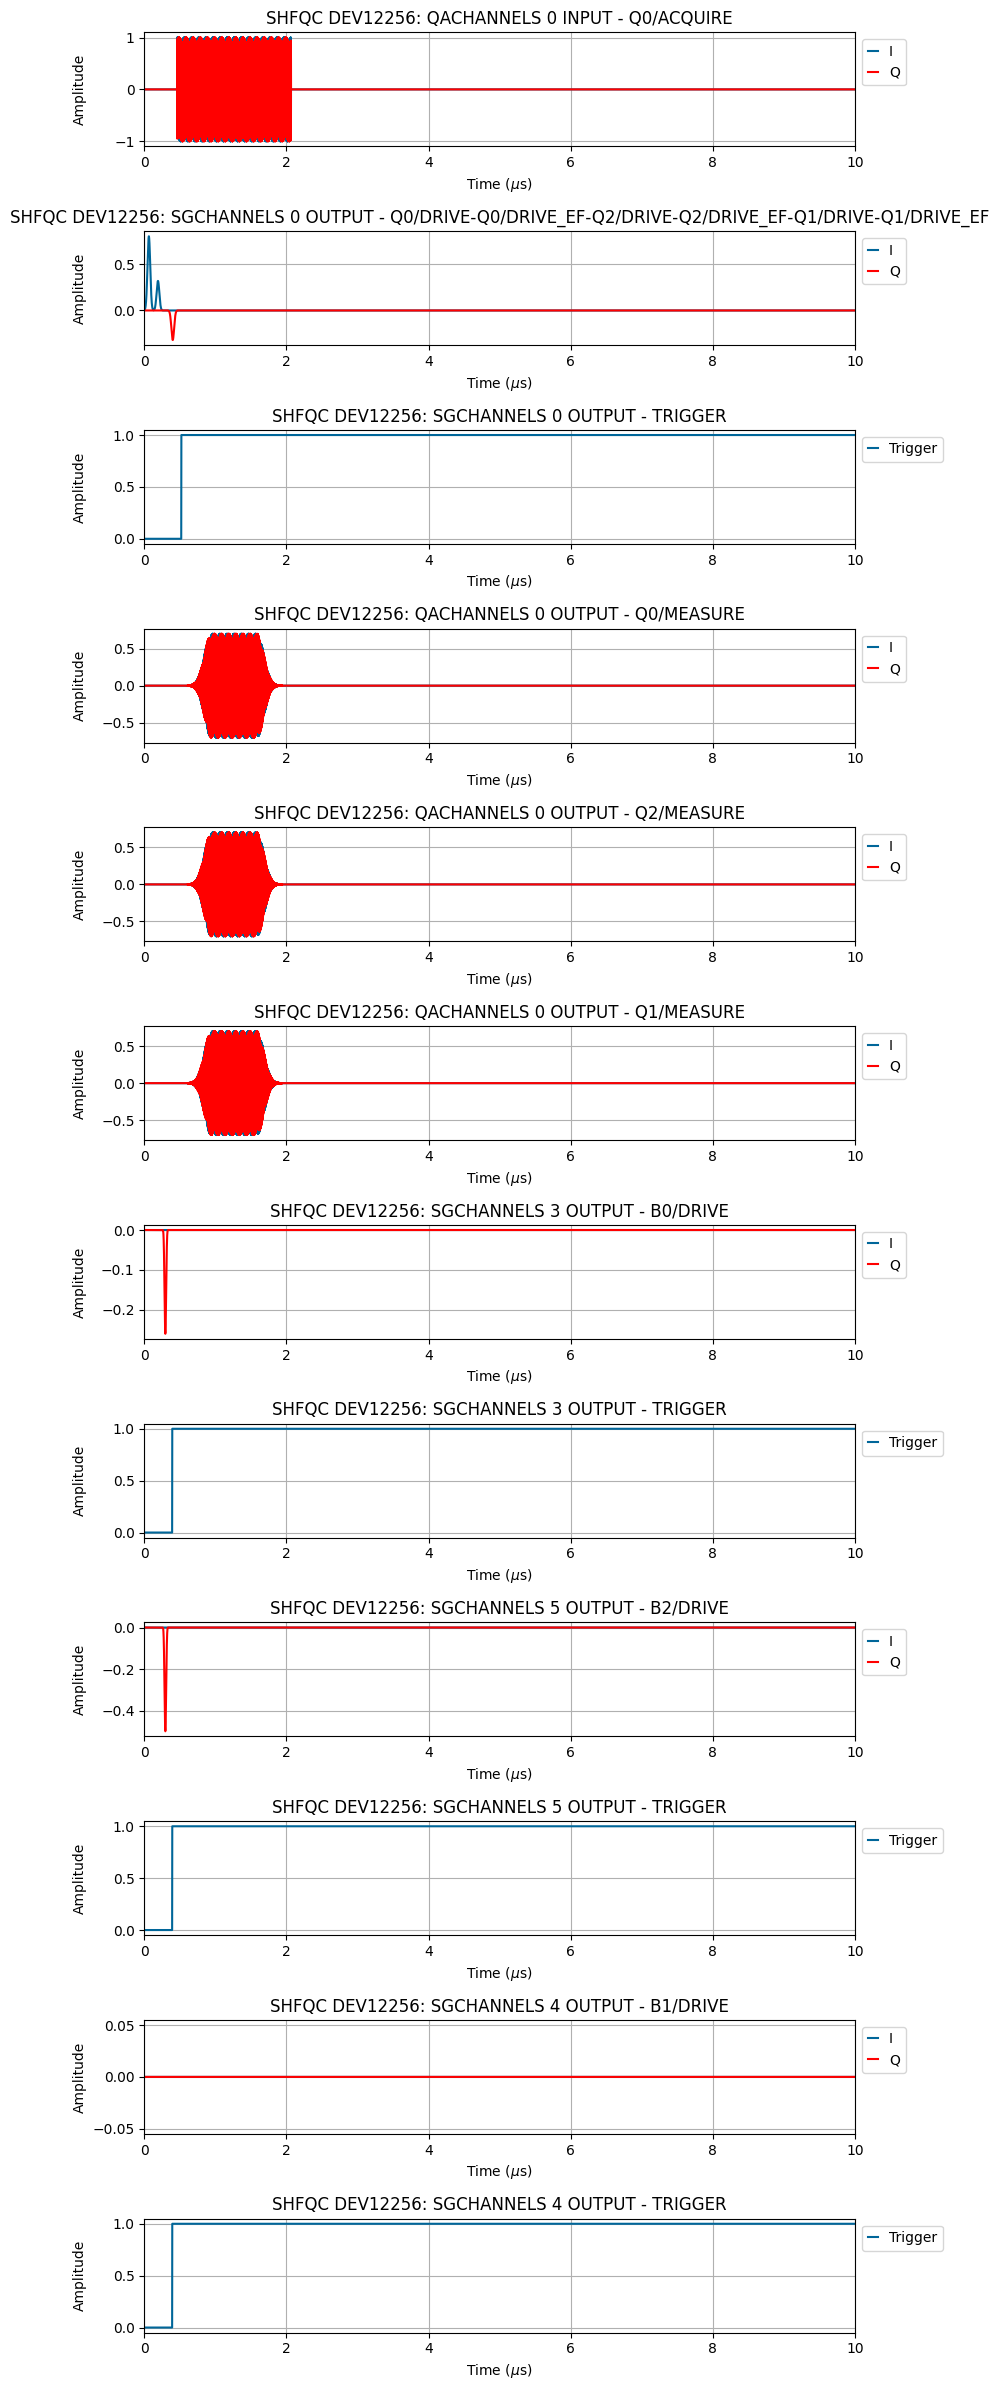

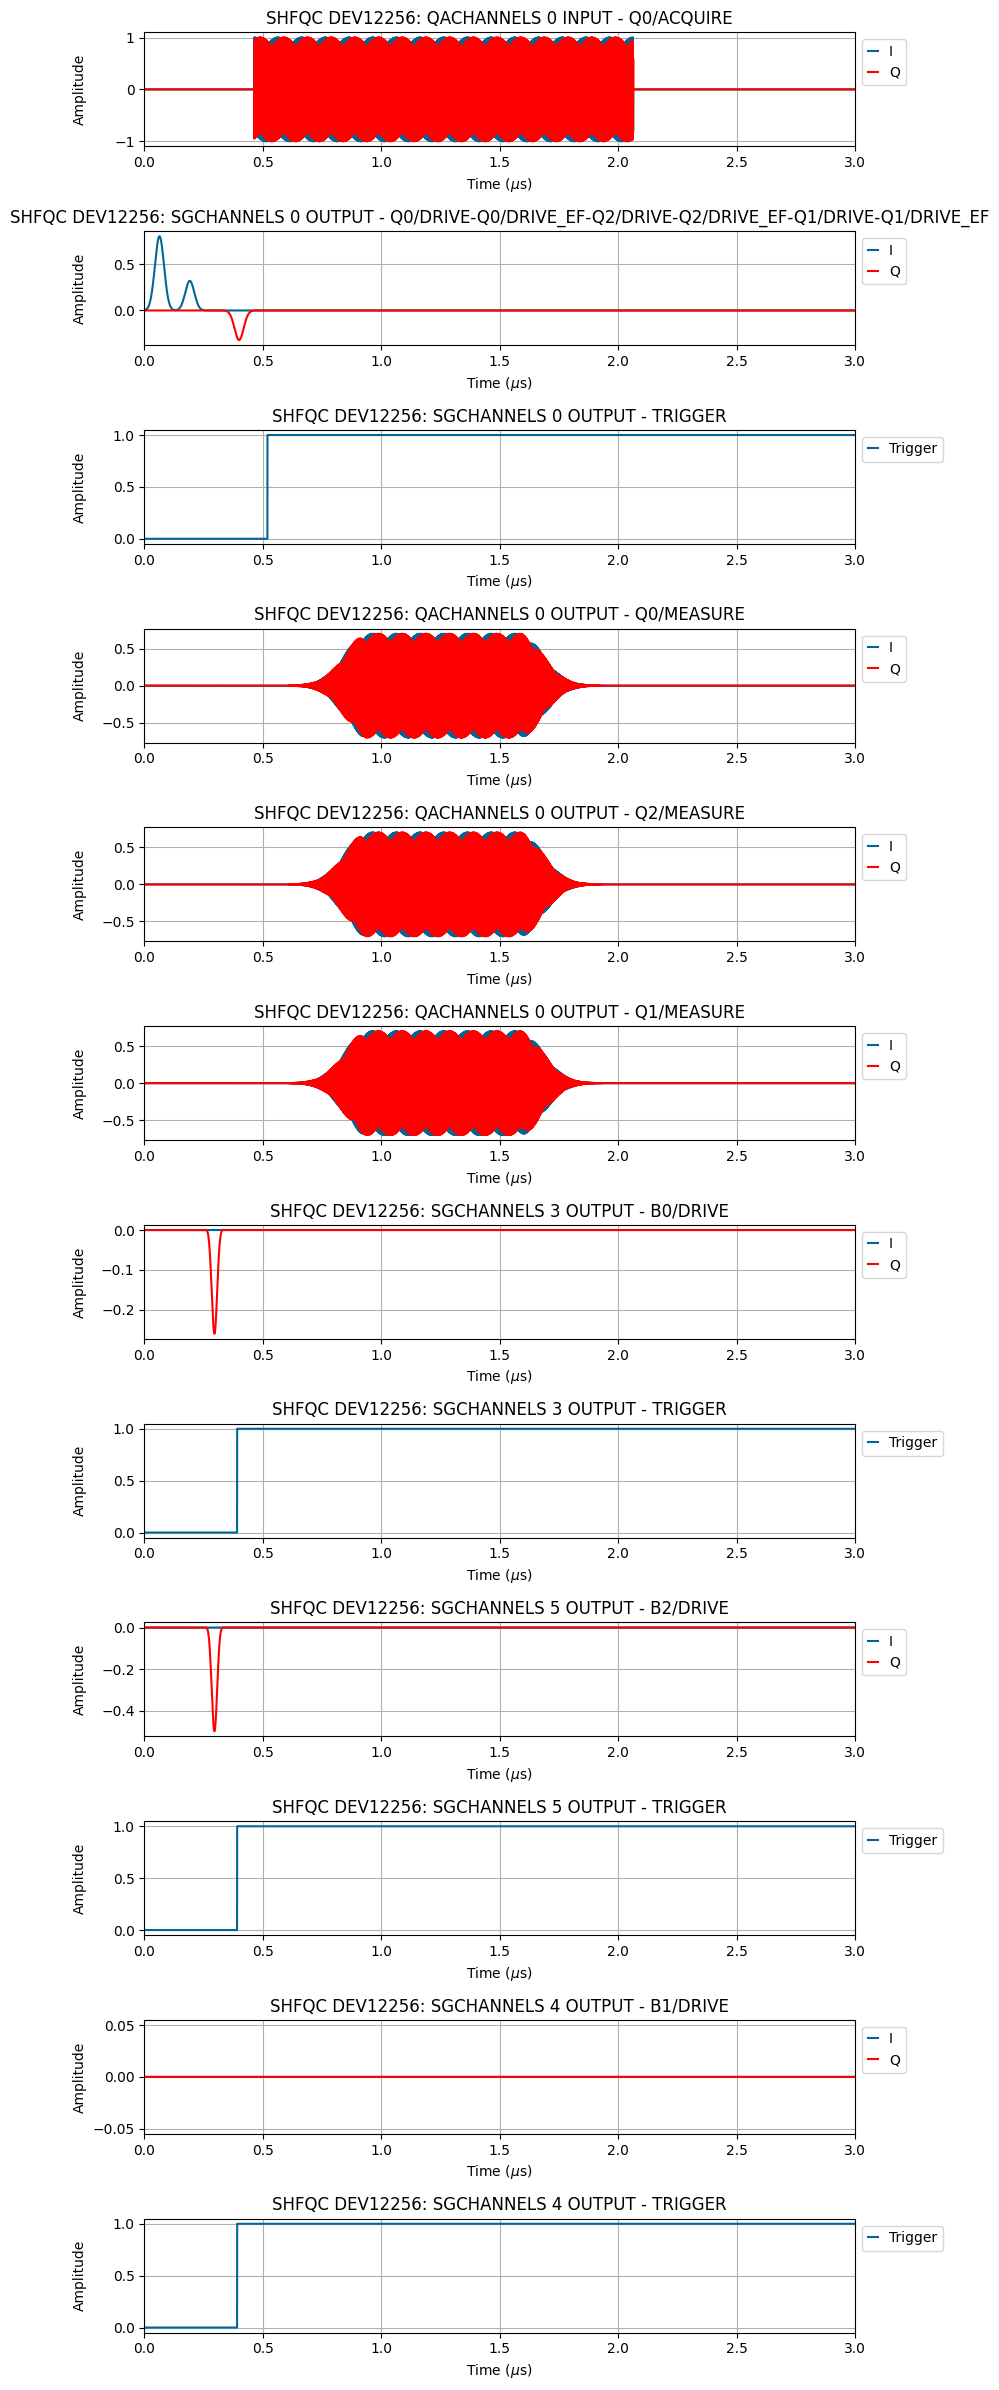

In [31]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

show_pulse_sheet(compiled_experiment=rip_result_specnop_ctrle.tasks["compile_experiment"].output,name='test', interactive=True)
plot_simulation(compiled_experiment=rip_result_specnop_ctrle.tasks["compile_experiment"].output)
plot_simulation(
    compiled_experiment=rip_result_specnop_ctrle.tasks["compile_experiment"].output,
    start_time=0.0e-6,  # 시작 시간
    length=3e-6       # 그 시점부터 볼 길이
)

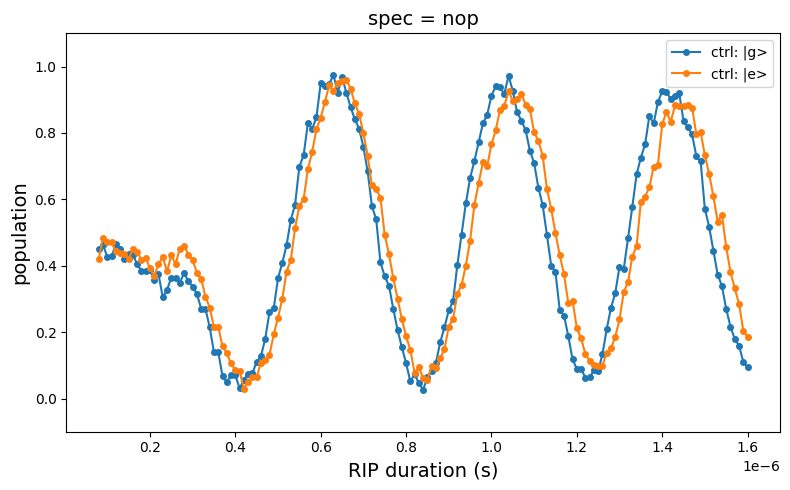

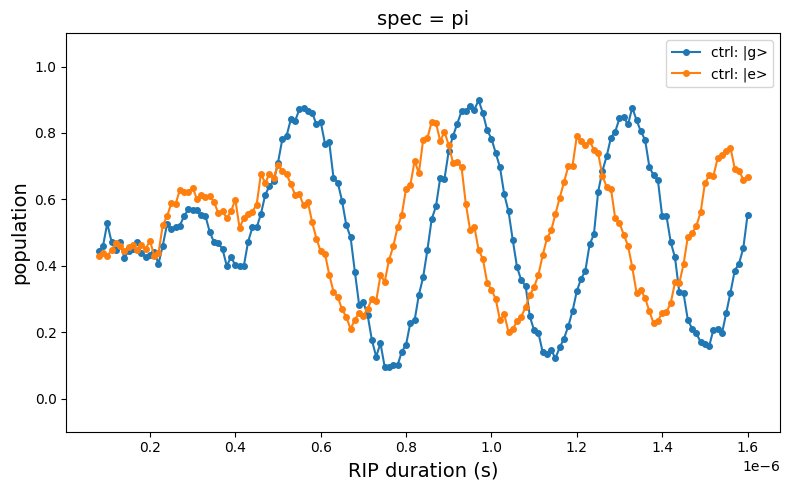

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

qt = "q2"  # 또는 qt = q_t.uid

def _flatten_chunked(x):
    """auto_chunking 등으로 object array(조각 배열)로 들어오는 경우까지 1D로 평탄화."""
    x = np.asarray(x)
    if x.dtype == object:
        return np.concatenate([np.ravel(np.asarray(xx)) for xx in x])
    return np.ravel(x)

def normalize_population(points, g, e):
    points = np.asarray(points, dtype=complex)
    diff = e - g
    return np.real((points - g) * np.conj(diff)) / np.abs(diff)**2

def extract_run(wf_result, qt):
    out = wf_result.output
    node = out.data[qt]

    duration = _flatten_chunked(node["result"].axis[0][0])
    sig = node["result"].data
    sig = _flatten_chunked(sig) if np.asarray(sig).dtype == object else np.asarray(sig)

    # cal points
    g_ref = node["cal_trace"].g.data
    e_ref = node["cal_trace"].e.data

    # ref도 chunked일 수 있어서 scalar로 만들기
    g_ref = np.asarray(g_ref).reshape(-1)[0]
    e_ref = np.asarray(e_ref).reshape(-1)[0]

    return duration, sig, g_ref, e_ref

def to_1d_population(sig, g_ref, e_ref):
    pop = normalize_population(sig, g_ref, e_ref)
    pop = np.asarray(pop)
    # sig가 (N, shots) 같은 형태면 shots 평균
    if pop.ndim > 1:
        pop = pop.mean(axis=-1)
    return np.ravel(pop)

def plot_spec_separated(results, qt, specs=("nop", "pi")):
    for spec in specs:
        res_g = results[(spec, "g")]
        res_e = results[(spec, "e")]

        dur_g, sig_g, gref_g, eref_g = extract_run(res_g, qt)
        dur_e, sig_e, gref_e, eref_e = extract_run(res_e, qt)

        # 보통 duration은 동일하지만, 혹시 달라도 안전하게 ctrl=g의 axis를 기준으로 사용
        duration = dur_g

        pop_g = to_1d_population(sig_g, gref_g, eref_g)
        pop_e = to_1d_population(sig_e, gref_e, eref_e)

        plt.figure(figsize=(8, 5))
        plt.plot(duration, pop_g, marker='o', ms=4, linestyle='-', label='ctrl: |g>')
        plt.plot(duration, pop_e, marker='o', ms=4, linestyle='-', label='ctrl: |e>')
        plt.ylim([-0.1, 1.1])
        plt.xlabel("RIP duration (s)", fontsize=14)
        plt.ylabel("population", fontsize=14)
        plt.title(f"spec = {spec}", fontsize=14)
        plt.legend()
        plt.tight_layout()

    plt.show()

# 사용 예:
results = {
  ("nop","g"): rip_result_specnop_ctrlg,
  ("nop","e"): rip_result_specnop_ctrle,
  ("pi","g"):  rip_result_specpi_ctrlg,
  ("pi","e"):  rip_result_specpi_ctrle,
}
plot_spec_separated(results, qt)



[spec=nop ctrl=g] f = 3.168206 ± 0.003860 MHz
[spec=nop ctrl=e] f = 2.082634 ± 0.009055 MHz
[spec=pi ctrl=g] f = 3.165842 ± 0.003565 MHz
[spec=pi ctrl=e] f = 2.086226 ± 0.009326 MHz


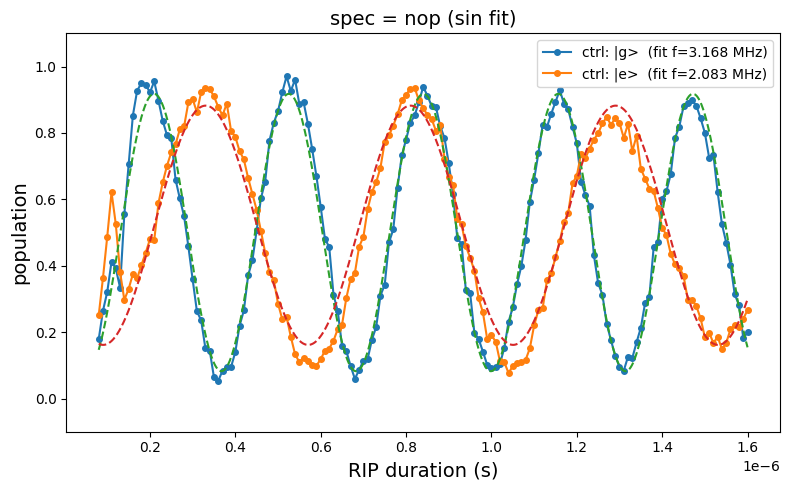

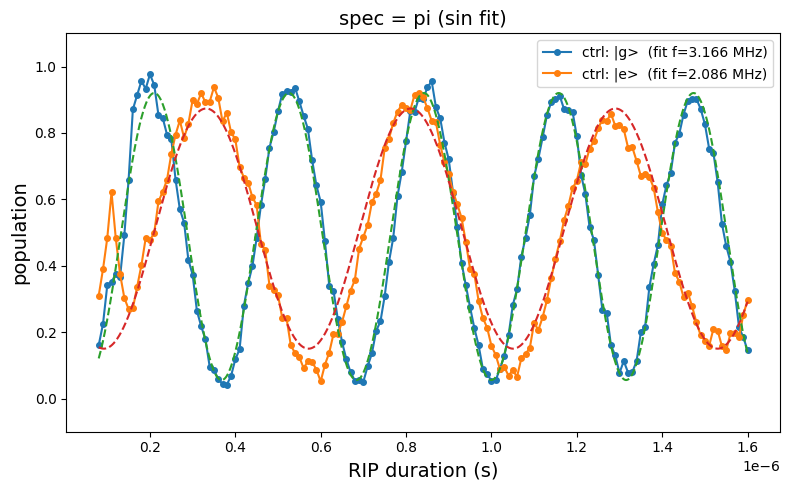

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) 너가 이미 쓰는 부분들 ---
def _flatten_chunked(x):
    x = np.asarray(x)
    if x.dtype == object:
        return np.concatenate([np.ravel(np.asarray(xx)) for xx in x])
    return np.ravel(x)

def normalize_population(points, g, e):
    points = np.asarray(points, dtype=complex)
    d0 = np.abs(points - g)
    d1 = np.abs(points - e)
    return d0 / (d0 + d1)

def extract_run(wf_result, qt):
    out = wf_result.output
    node = out.data[qt]

    duration = _flatten_chunked(node["result"].axis[0][0])  # seconds
    sig = node["result"].data
    sig = _flatten_chunked(sig) if np.asarray(sig).dtype == object else np.asarray(sig)

    g_ref = node["cal_trace"].g.data
    e_ref = node["cal_trace"].e.data
    g_ref = np.asarray(g_ref).reshape(-1)[0]
    e_ref = np.asarray(e_ref).reshape(-1)[0]

    return duration, sig, g_ref, e_ref

def to_1d_population(sig, g_ref, e_ref):
    pop = normalize_population(sig, g_ref, e_ref)
    pop = np.asarray(pop)
    if pop.ndim > 1:
        pop = pop.mean(axis=-1)
    return np.ravel(pop)

# --- 2) 피팅 유틸 (FFT로 f0 추정 + curve_fit) ---
def estimate_f0_fft(t, y):
    t = np.asarray(t)
    y = np.asarray(y)
    y0 = y - np.mean(y)

    # FFT는 등간격 샘플링 가정 (너는 linspace라 보통 OK)
    dt = np.median(np.diff(t))
    n = len(t)
    freqs = np.fft.rfftfreq(n, d=dt)
    Y = np.fft.rfft(y0)

    # DC 제외하고 peak 찾기
    mag = np.abs(Y)
    mag[0] = 0.0
    k = np.argmax(mag)
    f0 = freqs[k]
    return f0 if f0 > 0 else 1.0 / (t[-1] - t[0])

def model_cos(t, A, f, phi, C):
    return C + A * np.cos(2*np.pi*f*t + phi)

def model_cos_decay(t, A, f, phi, C, T):
    return C + A * np.exp(-t / T) * np.cos(2*np.pi*f*t + phi)

def fit_sinusoid(t, y, with_decay=False):
    t = np.asarray(t, float)
    y = np.asarray(y, float)

    # 초기값
    C0 = np.mean(y)
    A0 = 0.5 * (np.max(y) - np.min(y))
    f0 = estimate_f0_fft(t, y)
    phi0 = 0.0

    # bounds (너무 빡빡하지 않게)
    # A는 +/- 허용, f는 양수, C는 넓게, phi는 [-2pi, 2pi]
    if not with_decay:
        p0 = [A0, f0, phi0, C0]
        bounds = ([-2.0, 0.0, -2*np.pi, -1.0],
                  [ 2.0, np.inf,  2*np.pi,  2.0])
    else:
        # T 초기값: 측정 창의 절반 정도
        T0 = 0.5*(t[-1] - t[0]) if (t[-1] > t[0]) else 1e-6
        p0 = [A0, f0, phi0, C0, T0]
        bounds = ([-2.0, 0.0, -2*np.pi, -1.0, 1e-9],
                  [ 2.0, np.inf,  2*np.pi,  2.0, np.inf])

    # scipy 있으면 그걸로
    try:
        from scipy.optimize import curve_fit
        if not with_decay:
            popt, pcov = curve_fit(model_cos, t, y, p0=p0, bounds=bounds, maxfev=20000)
            perr = np.sqrt(np.diag(pcov))
            return popt, perr, model_cos
        else:
            popt, pcov = curve_fit(model_cos_decay, t, y, p0=p0, bounds=bounds, maxfev=30000)
            perr = np.sqrt(np.diag(pcov))
            return popt, perr, model_cos_decay

    except ImportError:
        # scipy 없으면: f만 그리드로 찾고(A,phi,C는 선형 최소자승)
        # (빠르고 꽤 잘 맞음)
        w0 = 2*np.pi*f0
        w_grid = np.linspace(0.5*w0, 1.5*w0, 2000)

        yv = y
        best = None
        for w in w_grid:
            X = np.column_stack([np.cos(w*t), np.sin(w*t), np.ones_like(t)])
            beta, *_ = np.linalg.lstsq(X, yv, rcond=None)
            yhat = X @ beta
            sse = np.mean((yv - yhat)**2)
            if (best is None) or (sse < best[0]):
                best = (sse, w, beta)

        _, w_best, beta = best
        B, D, C = beta
        A = np.sqrt(B**2 + D**2)
        phi = np.arctan2(-D, B)   # B*cos + D*sin = A*cos(wt+phi)
        f = w_best / (2*np.pi)
        popt = np.array([A, f, phi, C])
        perr = np.full_like(popt, np.nan)
        return popt, perr, model_cos

# --- 3) spec별 2개 figure, 각 figure에 ctrl=g/e 겹쳐 + 피팅 주파수 출력 ---
def plot_and_fit_spec(results, qt, specs=("nop","pi"), with_decay=False, dense_n=2000):
    fit_summary = {}

    for spec in specs:
        res_g = results[(spec, "g")]
        res_e = results[(spec, "e")]

        t_g, sig_g, gref_g, eref_g = extract_run(res_g, qt)
        t_e, sig_e, gref_e, eref_e = extract_run(res_e, qt)

        y_g = to_1d_population(sig_g, gref_g, eref_g)
        y_e = to_1d_population(sig_e, gref_e, eref_e)

        # 피팅 (각 trace 독립적으로)
        popt_g, perr_g, fmodel = fit_sinusoid(t_g, y_g, with_decay=with_decay)
        popt_e, perr_e, _      = fit_sinusoid(t_e, y_e, with_decay=with_decay)

        # 결과 정리: f는 popt[1]
        fg = popt_g[1]
        fe = popt_e[1]
        fit_summary[(spec,"g")] = (popt_g, perr_g)
        fit_summary[(spec,"e")] = (popt_e, perr_e)

        # plot
        plt.figure(figsize=(8,5))
        plt.plot(t_g, y_g, marker='o', ms=4, linestyle='-', label=f"ctrl: |g>  (fit f={fg/1e6:.3f} MHz)")
        plt.plot(t_e, y_e, marker='o', ms=4, linestyle='-', label=f"ctrl: |e>  (fit f={fe/1e6:.3f} MHz)")

        # fitted curve overlay (dense)
        tmin = min(t_g.min(), t_e.min())
        tmax = max(t_g.max(), t_e.max())
        tt = np.linspace(tmin, tmax, dense_n)

        plt.plot(tt, fmodel(tt, *popt_g), linestyle='--')
        plt.plot(tt, fmodel(tt, *popt_e), linestyle='--')

        plt.ylim([-0.1, 1.1])
        plt.xlabel("RIP duration (s)", fontsize=14)
        plt.ylabel("population", fontsize=14)
        plt.title(f"spec = {spec}" + (" (decay fit)" if with_decay else " (sin fit)"), fontsize=14)
        plt.legend()
        plt.tight_layout()

        # 콘솔 출력도 같이
        if np.all(np.isfinite(perr_g)):
            print(f"[spec={spec} ctrl=g] f = {fg/1e6:.6f} ± {perr_g[1]/1e6:.6f} MHz")
        else:
            print(f"[spec={spec} ctrl=g] f = {fg/1e6:.6f} MHz")
        if np.all(np.isfinite(perr_e)):
            print(f"[spec={spec} ctrl=e] f = {fe/1e6:.6f} ± {perr_e[1]/1e6:.6f} MHz")
        else:
            print(f"[spec={spec} ctrl=e] f = {fe/1e6:.6f} MHz")

    plt.show()
    return fit_summary

# ---- 사용 ----
qt = "q0"
fit_summary = plot_and_fit_spec(results, qt, with_decay=False)
# 감쇠까지 넣고 싶으면:
# fit_summary = plot_and_fit_spec(results, qt, with_decay=True)

## Bell state

In [57]:
from experiments import rip_bell_state

options = rip_bell_state.experiment_workflow.options()
options.update(False)

# ===== qubit / bus assign =====
q_s = qubits[1]
q_c = qubits[2]
q_t = qubits[0]

b1 = buses[0]
b2 = buses[2]
b3 = buses[1]

# ===== temporary parameters =====
temporary_parameters = {}

q_s_temp_pars = deepcopy(q_s.parameters)
q_c_temp_pars = deepcopy(q_c.parameters)
q_t_temp_pars = deepcopy(q_t.parameters)
q_t_temp_pars.readout_integration_length = 1.6e-6

temporary_parameters[q_s.uid] = q_s_temp_pars
temporary_parameters[q_c.uid] = q_c_temp_pars
temporary_parameters[q_t.uid] = q_t_temp_pars

# Bus 1 설정
b1_temp_pars = deepcopy(b1.parameters)
b1_temp_pars.drive_lo_frequency = 5.6e9
b1_temp_pars.resonance_frequency_bus = 5.5055e9
temporary_parameters[b1.uid] = b1_temp_pars

# Bus 2 설정
b2_temp_pars = deepcopy(b2.parameters)
b2_temp_pars.drive_lo_frequency = 6.2e9
b2_temp_pars.resonance_frequency_bus = 5.9807e9
temporary_parameters[b2.uid] = b2_temp_pars

# Bus 3 설정
b3_temp_pars = deepcopy(b3.parameters)
b3_temp_pars.drive_lo_frequency = 6.2e9
b3_temp_pars.resonance_frequency_bus = 6.4214e9
temporary_parameters[b3.uid] = b3_temp_pars

# ===== bus detuning & amplitude =====
D_detuning_1 = 20e6
D_detuning_2 = 16e6
D_detuning_3 = -60e6

bus1_freq = b1_temp_pars.resonance_frequency_bus + D_detuning_1
bus2_freq = b2_temp_pars.resonance_frequency_bus + D_detuning_2
bus3_freq = b3_temp_pars.resonance_frequency_bus + D_detuning_3

bus1_amp = 0.26
bus2_amp = 0.58
bus3_amp = 0.0

delays = np.linspace(80e-9, 1600e-9, 153)
detunings = -3.167e6

# =====================================================================
# ctrl = x90 중첩상태, spec nop/pi 비교
results = {}
for sp in ("nop", "pi"):
    job = rip_bell_state.experiment_workflow(
        session=session,
        qpu=qpu,
        spec=q_s,
        ctrl=q_c,
        targ=q_t,
        bus=b1,
        bus2=b2,
        bus3=b3,
        bus_frequency=bus1_freq,
        bus_amplitude=bus1_amp,
        bus2_frequency=bus2_freq,
        bus2_amplitude=bus2_amp,
        bus3_frequency=bus3_freq,
        bus3_amplitude=bus3_amp,
        delays=delays,
        detunings=detunings,
        spec_prep=sp,
        c_prep="x90",          # ✅ ctrl 중첩상태
        options=options,
        temporary_parameters=temporary_parameters,
    )
    results[sp] = job.run()

rip_result_specnop_ctrlx90 = results["nop"]
rip_result_specpi_ctrlx90  = results["pi"]

[2026.02.23 10:00:01.567] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.23 10:00:01.567] INFO      Workflow 'rip_bell_state': execution started at 2026-02-23 01:00:01.566583Z   
[2026.02.23 10:00:01.568] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.23 10:00:01.637] INFO    Task 'temporary_qpu': started at 2026-02-23 01:00:01.636600Z
[2026.02.23 10:00:01.640] INFO    Task 'temporary_qpu': ended at 2026-02-23 01:00:01.639601Z
[2026.02.23 10:00:01.654] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-23 
[2026.02.23 10:00:01.655] INFO    01:00:01.653602Z
[2026.02.23 10:00:01.656] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-02-23 01:00:01.656603Z
[2026.02.23 10:00:01.661] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-23 
[2026.02.23 10:00:01.661] INFO    01:00:01.660603Z
[2026.02.23 10:00:01.663] INFO    Task 'temporar

[2026.02.23 09:11:09.270] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2026.02.23 09:11:09.273] INFO    Resolved modulation type of oscillator 'b0_drive_osc' on signal 'b0/drive' to HARDWARE
[2026.02.23 09:11:09.274] INFO    Resolved modulation type of oscillator 'b1_drive_osc' on signal 'b1/drive' to HARDWARE
[2026.02.23 09:11:09.275] INFO    Resolved modulation type of oscillator 'b2_drive_osc' on signal 'b2/drive' to HARDWARE
[2026.02.23 09:11:09.275] INFO    Resolved modulation type of oscillator 'q0_readout_acquire_osc' on signal 'q0/acquire' to SOFTWARE
[2026.02.23 09:11:09.276] INFO    Resolved modulation type of oscillator 'q0_drive_ge_osc' on signal 'q0/drive' to HARDWARE
[2026.02.23 09:11:09.276] INFO    Resolved modulation type of oscillator 'q0_drive_ef_osc' on signal 'q0/drive_ef' to HARDWARE

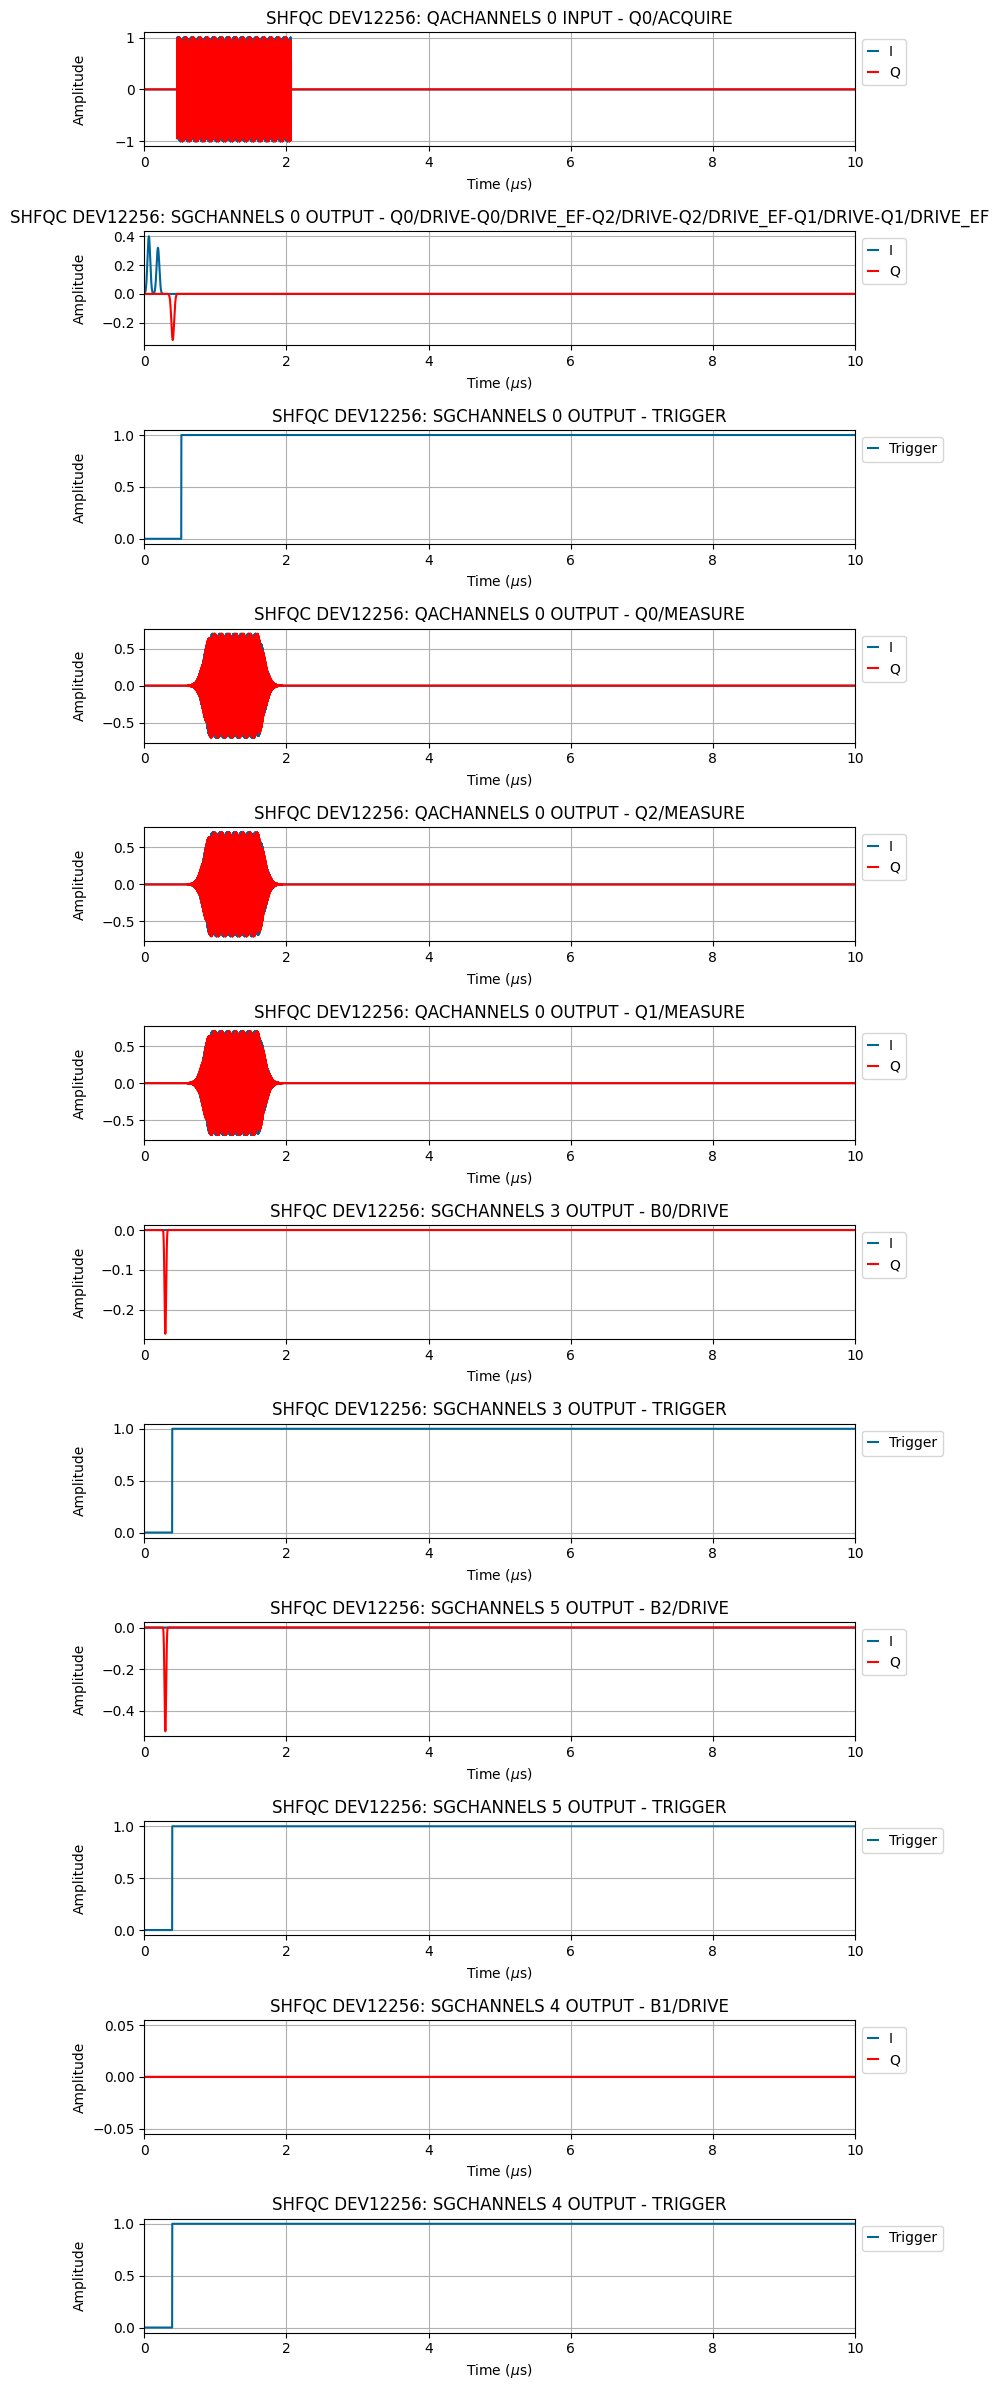

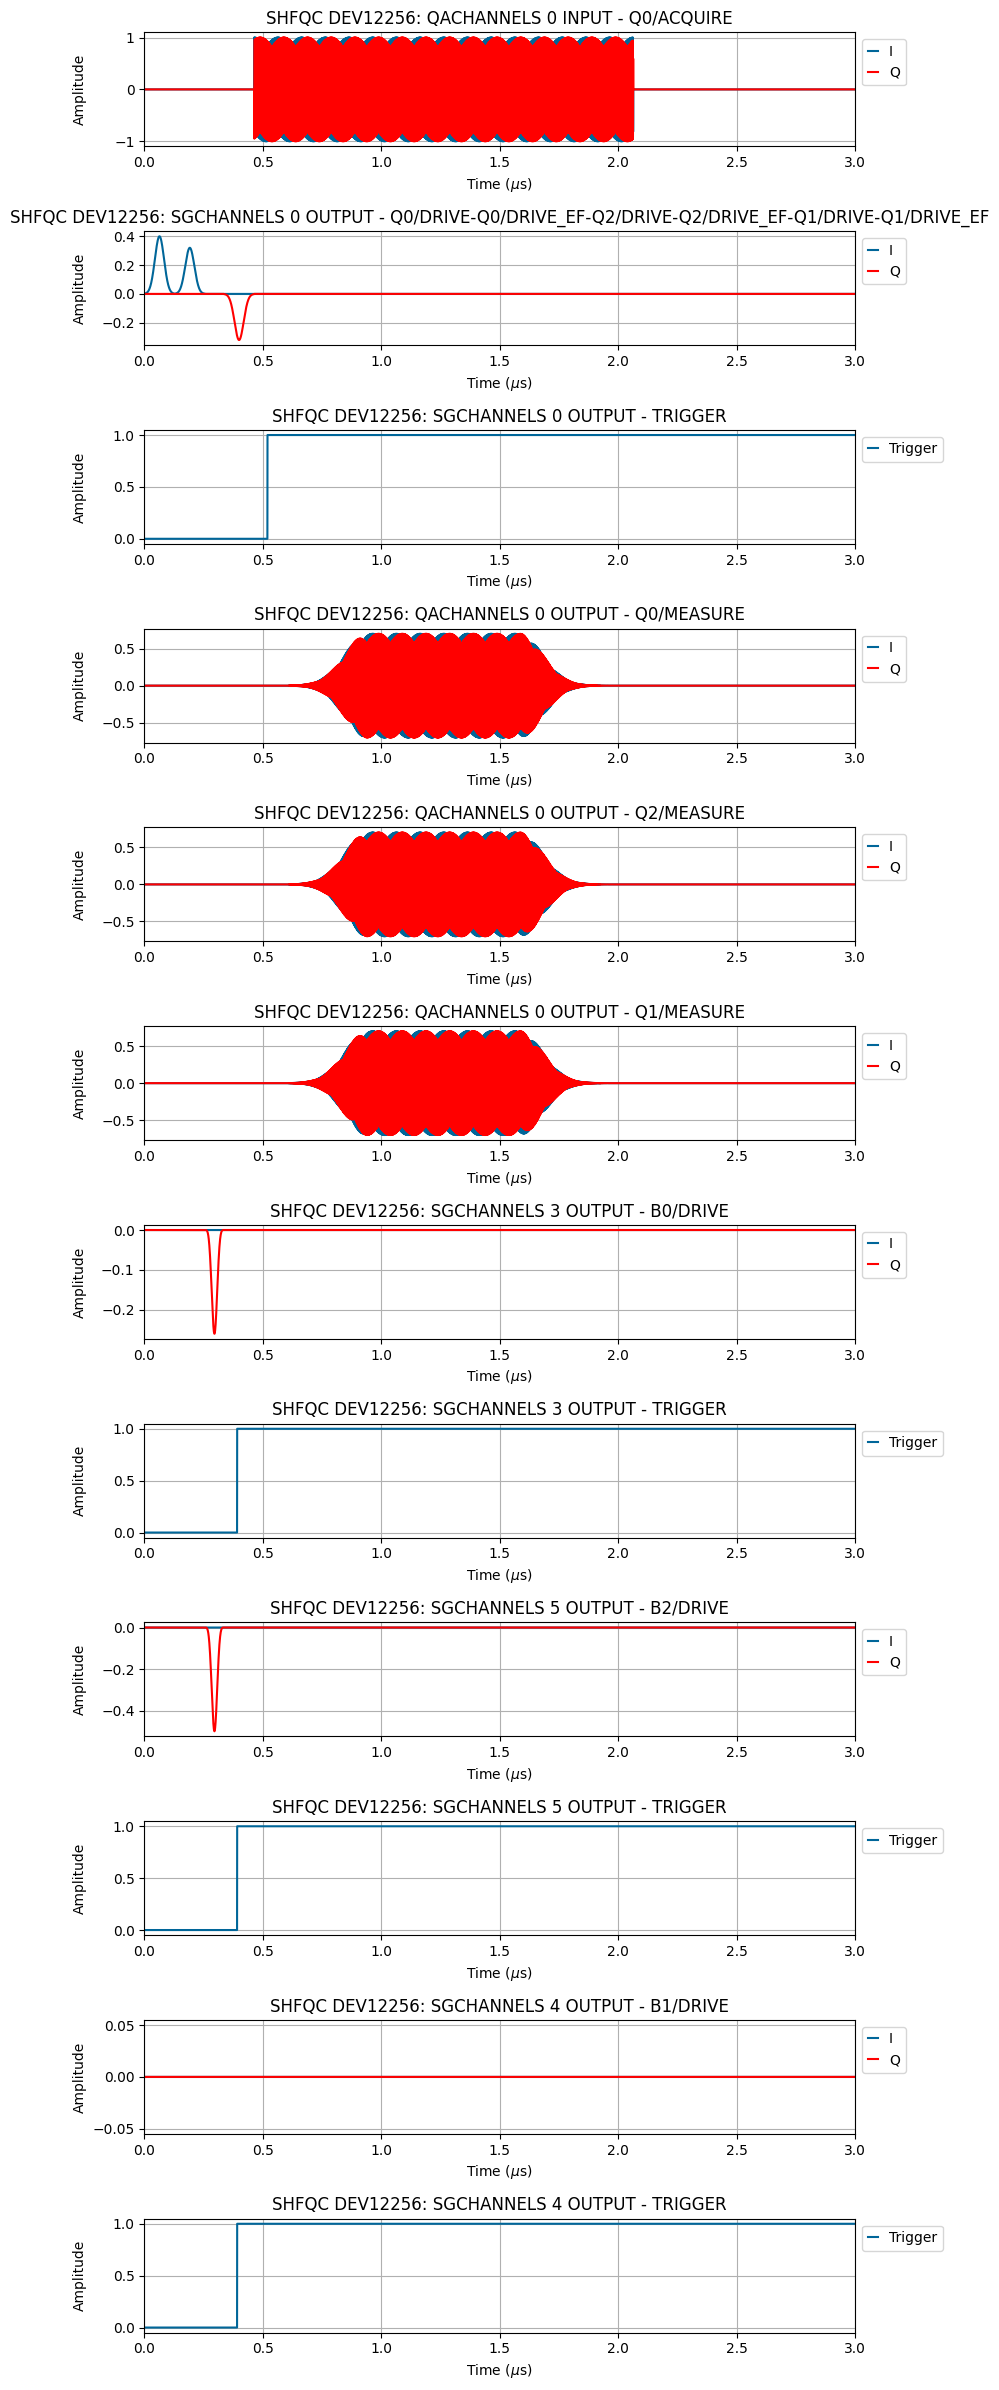

In [29]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

show_pulse_sheet(compiled_experiment=rip_result_specnop_ctrlx90.tasks["compile_experiment"].output,name='test', interactive=True)
plot_simulation(compiled_experiment=rip_result_specnop_ctrlx90.tasks["compile_experiment"].output)
plot_simulation(
    compiled_experiment=rip_result_specnop_ctrlx90.tasks["compile_experiment"].output,
    start_time=0.0e-6,  # 시작 시간
    length=3e-6       # 그 시점부터 볼 길이
)

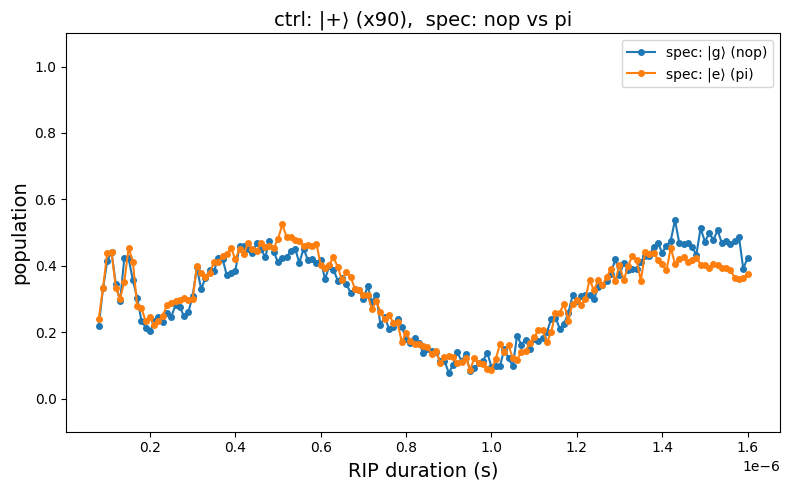

In [58]:
import numpy as np
import matplotlib.pyplot as plt

qt = "q0"  # 또는 qt = q_t.uid

def _flatten_chunked(x):
    """auto_chunking 등으로 object array(조각 배열)로 들어오는 경우까지 1D로 평탄화."""
    x = np.asarray(x)
    if x.dtype == object:
        return np.concatenate([np.ravel(np.asarray(xx)) for xx in x])
    return np.ravel(x)

def normalize_population(points, g, e):
    points = np.asarray(points, dtype=complex)
    d0 = np.abs(points - g)
    d1 = np.abs(points - e)
    return d0 / (d0 + d1)

def extract_run(wf_result, qt):
    out = wf_result.output
    node = out.data[qt]

    duration = _flatten_chunked(node["result"].axis[0][0])
    sig = node["result"].data
    sig = _flatten_chunked(sig) if np.asarray(sig).dtype == object else np.asarray(sig)

    # cal points
    g_ref = node["cal_trace"].g.data
    e_ref = node["cal_trace"].e.data

    g_ref = np.asarray(g_ref).reshape(-1)[0]
    e_ref = np.asarray(e_ref).reshape(-1)[0]

    return duration, sig, g_ref, e_ref

def to_1d_population(sig, g_ref, e_ref):
    pop = normalize_population(sig, g_ref, e_ref)
    pop = np.asarray(pop)
    if pop.ndim > 1:
        pop = pop.mean(axis=-1)
    return np.ravel(pop)

# =====================================================================
# ctrl = x90 고정, spec nop vs pi 비교 플롯
# =====================================================================
def plot_ctrl_x90(results, qt):
    """results = {"nop": wf_result, "pi": wf_result}"""

    dur_nop, sig_nop, gref_nop, eref_nop = extract_run(results["nop"], qt)
    dur_pi,  sig_pi,  gref_pi,  eref_pi  = extract_run(results["pi"],  qt)

    pop_nop = to_1d_population(sig_nop, gref_nop, eref_nop)
    pop_pi  = to_1d_population(sig_pi,  gref_pi,  eref_pi)

    plt.figure(figsize=(8, 5))
    plt.plot(dur_nop, pop_nop, marker='o', ms=4, linestyle='-', label='spec: |g⟩ (nop)')
    plt.plot(dur_pi,  pop_pi,  marker='o', ms=4, linestyle='-', label='spec: |e⟩ (pi)')
    plt.ylim([-0.1, 1.1])
    plt.xlabel("RIP duration (s)", fontsize=14)
    plt.ylabel("population", fontsize=14)
    plt.title("ctrl: |+⟩ (x90),  spec: nop vs pi", fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 사용:
results = {
    "nop": rip_result_specnop_ctrlx90,
    "pi":  rip_result_specpi_ctrlx90,
}
plot_ctrl_x90(results, qt)